# Creating Dirty-MNIST
> This notebook creates Dirty-MNIST.

In [130]:
# hide
from nbdev.showdoc import *

## Overview

We train a VAE on the original MNIST dataset to be able to synthesize new MNIST digits. Then, we train an ensemble of LeNet models on MNIST that we can use to select ambiguous samples from the VAE.

To save progress and save resources, we cache all models locally.

## Prerequisites

In [2]:
from functools import wraps

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm.auto import tqdm

Load MNIST:

In [3]:
torch.manual_seed(1)

batch_size = 128

# MNIST Dataset
mnist_mean, mnist_std = 0.1307, 0.3081

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mnist_mean,), (mnist_std,))])

train_dataset = datasets.MNIST(root="./mnist_data/", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./mnist_data/", train=False, transform=transform, download=True)

# Data Loader (Input Pipeline)
mnist_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
def unwhiten_mnist(x):
    return x * mnist_std + mnist_mean

In [5]:
def whiten_mnist(x):
    return (x - mnist_mean) / mnist_std

A little helper function to make it easy to backup and restore resources:

In [6]:
def restore_or_create(file_or_path, recreate: bool = False, *, pickle_module=None, pickle_load_args={}):
    pickle_module_arg = dict(pickle_module=pickle_module) if pickle_module else {}

    def delegate(func):
        @wraps(func)
        def wrapper():
            if not recreate:
                try:
                    return torch.load(file_or_path, {**pickle_load_args, **pickle_module_arg})
                except FileNotFoundError:
                    pass
            result = func()
            torch.save(result, file_or_path, pickle_protocol=-1, **pickle_module_arg)
            return result

        return wrapper

    return delegate

## VAE Training

In [7]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)  # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)  # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return (F.sigmoid(self.fc6(h)) - mnist_mean) / mnist_std

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [8]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(unwhiten_mnist(recon_x), unwhiten_mnist(x).view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [9]:
def train_vae_epoch(vae, optimizer, train_loader, epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss / len(train_loader.dataset)))

In [10]:
def test_vae(vae, test_loader):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))

In [11]:
import os

In [12]:
@restore_or_create("vae_ambiguous_mnist.model", recreate=False)
def train_vae():
    z_dim = 32
    # build model
    vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=z_dim)
    if torch.cuda.is_available():
        vae.cuda()

    optimizer = optim.Adam(vae.parameters())
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 50, 65], gamma=0.2)

    os.makedirs("./samples", exist_ok=True)
    for epoch in tqdm(range(1, 75)):
        train_vae_epoch(vae, optimizer, mnist_train_loader, epoch)
        test_vae(vae, mnist_test_loader)
        scheduler.step()
        with torch.no_grad():
            z = torch.randn(64, z_dim).cuda()
            # print (z.shape)
            sample = vae.decoder(z).cuda()
            save_image(unwhiten_mnist(sample.view(64, 1, 28, 28)), "./samples/sample_" + str(epoch) + ".png")

    return vae


vae = train_vae()
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=32, bias=True)
  (fc32): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
from torchvision.utils import make_grid


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

In [14]:
def post_process_amnist(sample):
    unwhitened = unwhiten_mnist(sample)
    unwhitened = torch.clamp(1.6 * unwhitened, 0, 1) ** 1.2
    return unwhitened

/home/blackhc/anaconda3/envs/ddu_dirty_mnist/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


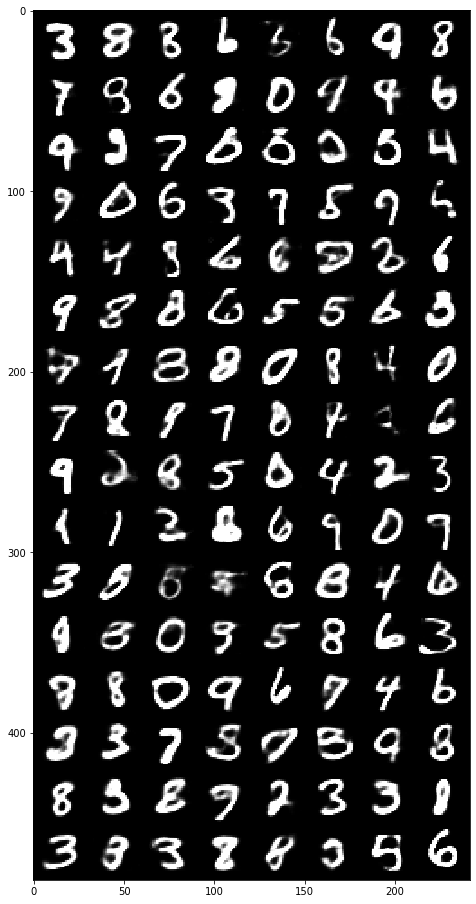

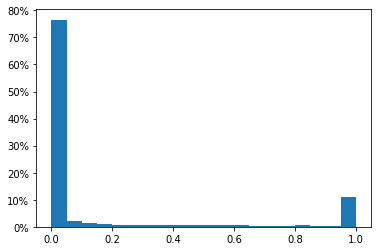

In [15]:
plt.figure(figsize=(8, 16))

with torch.no_grad():
    z = torch.randn(128, 32).cuda()
    # print (z.shape)
    sample = vae.decoder(z).cuda()
    unwhitened = post_process_amnist(sample.view(128, 1, 28, 28))
    show(make_grid(unwhitened, normalize=False, scale_each=False))
    plt.show()
    plt.hist(unwhitened.cpu().flatten().numpy(), bins=20)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=unwhitened.numel()))

tensor(0.) tensor(1.)


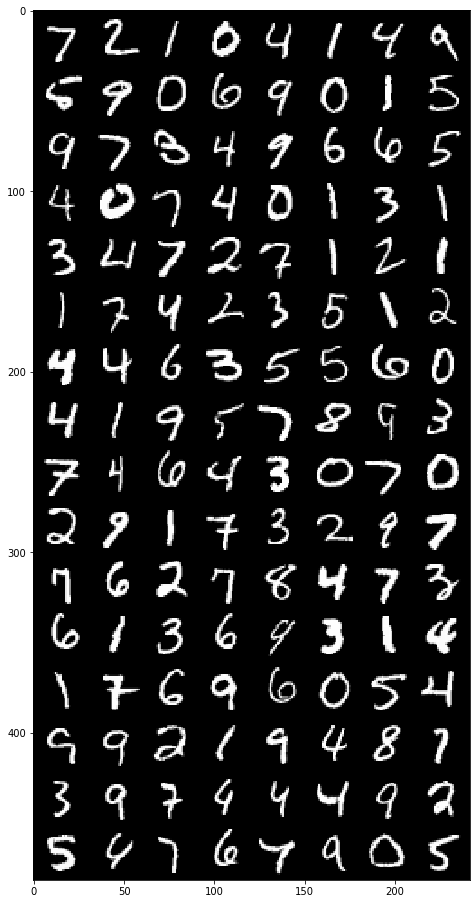

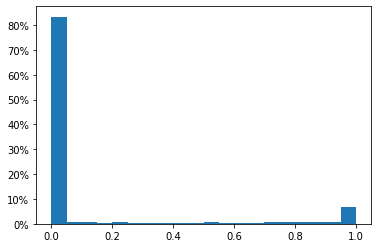

In [16]:
plt.figure(figsize=(8, 16))
for data, _ in mnist_test_loader:
    unwhitened = unwhiten_mnist(data.view(batch_size, 1, 28, 28))
    print(unwhitened.min(), unwhitened.max())
    show(make_grid(unwhitened, normalize=False, scale_each=False))
    plt.show()
    plt.hist(unwhitened.cpu().flatten().numpy(), bins=20)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=unwhitened.numel()))
    break

# LeNet Ensemble for Classification

In [16]:
# Train a LeNet on MNIST
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [17]:
num_ensemble_components = 5

In [18]:
def lenet_train(epoch, train_loader, optimizer, lenet):
    lenet.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.cuda()
        label = label.cuda()
        optimizer.zero_grad()

        out = lenet(data)
        loss = F.cross_entropy(out, label)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )
    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss / len(train_loader.dataset)))


def lenet_test(test_loader, lenet):
    lenet.eval()
    test_loss = 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.cuda()
            label = label.cuda()
            out = lenet(data)

            # sum up batch loss
            test_loss += F.cross_entropy(out, label).item()

    test_loss /= len(test_loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))
    return test_loss

In [19]:
lenets = []

for i in range(num_ensemble_components):

    @restore_or_create(f"lenet_model_{i}.model")
    def train_lenet_model():
        lenet = LeNet(num_classes=10).cuda()
        optimizer = optim.Adam(lenet.parameters())

        best_loss = None
        best_epoch = None
        for epoch in tqdm(
            range(1, 101 // num_ensemble_components)
        ):  # lenet seems to converge after about 10 epochs anyways..
            lenet_train(epoch, mnist_train_loader, optimizer, lenet)
            test_loss = lenet_test(mnist_test_loader, lenet)
            if not best_loss or best_loss > test_loss:
                torch.save(lenet.state_dict(), "./tmp_lenet_best.model")
                best_loss = test_loss
                best_epoch = epoch
                print("New best model", best_epoch, " with ", best_loss)

        print("Best epoch", best_epoch)

        lenet.load_state_dict(torch.load("./tmp_lenet_best.model"))
        return lenet

    lenets.append(train_lenet_model())

# Create ambiguous samples

In [20]:
import numpy as np

np.random.seed(1)

import matplotlib.pyplot as plt

plt.rcParams["figure.facecolor"] = "white"

In [21]:
def pred_entropy(pre_softmaxs):  # shape: [MC samples from pred / ensemble, num data, classes]
    softmaxs = F.softmax(pre_softmaxs, dim=-1)
    softmax = torch.mean(softmaxs, dim=0)
    logits = torch.log(softmax)
    nats = -logits * softmax
    nats[torch.isnan(nats)] = 0.0
    return nats.sum(dim=-1)


def avg_entropy(pre_softmaxs):  # shape: [MC samples from pred / ensemble, num data, classes]
    # NOTE: looking at average ent, not pred ent
    softmax = F.softmax(pre_softmaxs, dim=-1)
    logits = F.log_softmax(pre_softmaxs, dim=-1)
    nats = -logits * softmax
    nats[torch.isnan(nats)] = 0.0
    nats = nats.sum(dim=-1)  # sum over classes
    return nats.mean(dim=0)  # average over MC samples!

In [22]:
class_indices = [np.nonzero((train_dataset.targets == c).cpu().numpy())[0] for c in range(10)]

In [23]:
@restore_or_create("ambiguous_samples.pt", recreate=False)
def create_ambiguous_samples():
    num_samples_per_pair = 8

    ambig_decoded_images = []

    num_label_range = list(range(2, 5))

    batch_size = 64

    num_amb_examples = 2000
    with torch.no_grad():
        for num_labels in tqdm(num_label_range):
            ambig_sample_progress = tqdm(range(num_amb_examples))
            num_new_samples = 0
            while num_new_samples < num_amb_examples:
                batch_labels = []
                batch_data = []
                for j in range(batch_size):
                    label = np.random.choice(10, num_labels, replace=False)
                    batch_indices = [np.random.choice(len(class_indices[c]), 1)[0] for c in label]
                    data = torch.stack([train_dataset[i][0] for i in batch_indices]).cuda()
                    label = torch.tensor(label).cuda()
                    batch_labels.append(label)
                    batch_data.append(data)

                batch_data = torch.stack(batch_data)
                batch_labels = torch.stack(batch_labels)

                mu, logvar = vae.encoder(batch_data.view(-1, 784))

                mix_weights = torch.rand(batch_size * num_samples_per_pair, num_labels + 1).cuda()
                mix_weights[:, 0] = 0
                mix_weights[:, -1] = 1
                mix_weights = torch.sort(mix_weights, dim=-1)[0]
                mix_weights = mix_weights[:, 1:] - mix_weights[:, :-1]
                mixed_encodings = mix_weights.view(batch_size, num_samples_per_pair, num_labels) @ mu.view(
                    batch_size, num_labels, -1
                )
                decoded_lerps = vae.decoder(mixed_encodings).view(batch_size * num_samples_per_pair, 1, 28, 28)

                whitened_samples = whiten_mnist(calibrated_post_process_amnist(decoded_lerps))
                lenet_pre_softmaxs = [lenet(whitened_samples.cuda()) for lenet in lenets]
                lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
                batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
                batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
                batch_mi = batch_pred_entropies - batch_avg_entropies
                ambiguous_samples = (batch_pred_entropies > 0.05) & (batch_mi < 0.1)

                ambig_decoded_images.append(decoded_lerps[ambiguous_samples].cpu())
                num_new_samples += ambiguous_samples.sum().item()
                ambig_sample_progress.update(ambiguous_samples.sum().item())

            ambig_sample_progress.close()

    ambig_decoded_images = torch.cat(ambig_decoded_images).cpu()

    return ambig_decoded_images


ambig_decoded_images = create_ambiguous_samples()

# Calibrate the output of the VAE to match real MNIST as much as possible

In [25]:
@restore_or_create("unambiguous_samples.pt", recreate=False)
@torch.no_grad()
def create_unambiguous_samples():
    decoded_images = []
    decoded_labels = []

    batch_size = 1024

    num_amb_examples = 60000
    num_new_samples = 0

    sample_progress = tqdm(range(num_amb_examples))

    while num_new_samples < num_amb_examples:
        z = torch.randn(batch_size, 32).cuda()
        decoded_lerps = vae.decoder(z).view(batch_size, 1, 28, 28)

        whitened_samples = whiten_mnist(decoded_lerps)
        lenet_pre_softmaxs = [lenet(whitened_samples.cuda()) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)

        batch_labels = F.softmax(lenet_pre_softmaxs, dim=-1).mean(dim=0).argmax(dim=-1)
        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
        batch_mi = batch_pred_entropies - batch_avg_entropies
        ambiguous_samples = (batch_pred_entropies < 0.05) & (batch_mi < 0.1)

        decoded_images.append(decoded_lerps[ambiguous_samples].cpu())
        decoded_labels.append(batch_labels[ambiguous_samples].cpu())

        num_new_samples += ambiguous_samples.sum().item()

        sample_progress.update(ambiguous_samples.sum().item())

    sample_progress.close()

    decoded_images = torch.cat(decoded_images).cpu()
    decoded_labels = torch.cat(decoded_labels).cpu()
    return decoded_images, decoded_labels


unambiguous_decoded_images, unambiguous_decoded_labels = create_unambiguous_samples()

In [26]:
unambiguous_decoded_labels.shape

torch.Size([60045])

## Create histogram of MNIST

In [27]:
[len(ci) for ci in class_indices]

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

In [28]:
smallest_class_size = min([len(ci) for ci in class_indices])
smallest_class_size

5421

Sample 5421 each from each class:

In [29]:
balanced_mnist = torch.cat([mnist_train_loader.dataset.data[ci[:smallest_class_size]] for ci in class_indices])

(array([0.81640133, 0.00823395, 0.00682086, 0.00541949, 0.005625  ,
       0.0053679 , 0.00519218, 0.00417485, 0.00499804, 0.00457014,
       0.00604344, 0.00472626, 0.00472859, 0.00533143, 0.00568791,
       0.00540999, 0.00605664, 0.00704276, 0.00860288, 0.07956635]), array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))


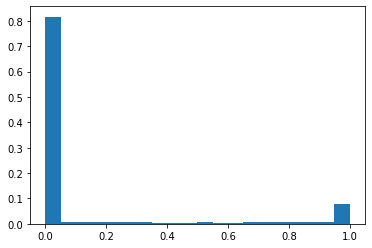

In [30]:
# compute a histogram for MNIST
num_histogram_bins = 20
mnist_train_histogram = np.histogram(balanced_mnist.numpy(), bins=num_histogram_bins)
mnist_train_histogram = (
    mnist_train_histogram[0] / balanced_mnist.numel(),
    mnist_train_histogram[1] / 255.0,
)
print(mnist_train_histogram)
plt.bar(mnist_train_histogram[1][:-1], mnist_train_histogram[0], align="edge", width=0.05)
plt.show()

We see two peaks: 82% of the pixels are close to 0 and 7.9% are close to 1.

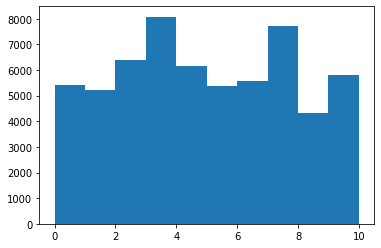

In [31]:
vae_mnist_label_histogram = np.histogram(unambiguous_decoded_labels.numpy(), bins=10, range=[0, 10])
plt.bar(vae_mnist_label_histogram[1][:-1], vae_mnist_label_histogram[0], align="edge", width=1)
plt.show()

In [32]:
smallest_class_size = min(vae_mnist_label_histogram[0])
smallest_class_size

4331

In [33]:
balanced_vae_mnist = torch.cat(
    [unambiguous_decoded_images.data[unambiguous_decoded_labels == c][:smallest_class_size] for c in range(10)]
)

In [34]:
balanced_vae_mnist.shape

torch.Size([43310, 1, 28, 28])

In [35]:
vae_mnist_mean = torch.mean(balanced_vae_mnist)
vae_mnist_std = torch.std(balanced_vae_mnist)
print(vae_mnist_mean, vae_mnist_std)

vae_mnist_min, vae_mnist_max = balanced_vae_mnist.min(), balanced_vae_mnist.max()
print(vae_mnist_min, vae_mnist_max)

tensor(-0.0082) tensor(0.9003)
tensor(-0.4242) tensor(2.8215)


In [36]:
def calibrated_post_process_vae_mnist(sample):
    # unwhitened = (sample - mnist_in_amnist_min) / (mnist_in_amnist_max - mnist_in_amnist_min)
    # unwhitened = torch.clamp(1.4 * unwhitened, 0, 1)**1.4
    # unwhitened = unwhiten_mnist(unwhitened)

    whitened_amnist = (sample - vae_mnist_mean) / vae_mnist_std
    unwhitened_mnist = unwhiten_mnist(whitened_amnist)
    unwhitened_mnist = torch.clamp(1.3 * unwhitened_mnist - 0.15, 0, 1)
    return unwhitened_mnist

(array([0.80921301, 0.00868498, 0.00753997, 0.00681516, 0.00628764,
       0.00590457, 0.00564623, 0.00545545, 0.00534345, 0.00528216,
       0.00525524, 0.00535399, 0.00540577, 0.00554613, 0.00573865,
       0.00600647, 0.00631308, 0.00670872, 0.00723754, 0.08026178]), array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
      dtype=float32))


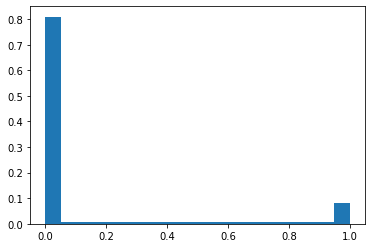

In [37]:
# compute a histogram for VAE-MNIST
vae_mnist_train_histogram = np.histogram(
    calibrated_post_process_vae_mnist(balanced_vae_mnist).numpy(), bins=num_histogram_bins, range=[0, 1]
)
vae_mnist_train_histogram = (
    vae_mnist_train_histogram[0] / balanced_vae_mnist.numel(),
    vae_mnist_train_histogram[1],
)
print(vae_mnist_train_histogram)
plt.bar(vae_mnist_train_histogram[1][:-1], vae_mnist_train_histogram[0], align="edge", width=0.05)
plt.show()

In [188]:
@restore_or_create("ambiguous_samples.pt", recreate=False)
@torch.no_grad()
def create_ambiguous_samples():
    ambig_decoded_images = []

    batch_size = 1024

    num_amb_examples = 1000000
    num_new_samples = 0
    ambig_sample_progress = tqdm(range(num_amb_examples))
    while num_new_samples < num_amb_examples:
        z = torch.randn(batch_size, 10).cuda()
        decoded_lerps = vae.decoder(z).view(batch_size, 1, 28, 28)

        whitened_samples = whiten_mnist(calibrated_post_process_amnist(decoded_lerps))
        lenet_pre_softmaxs = [lenet(whitened_samples.cuda()) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
        batch_mi = batch_pred_entropies - batch_avg_entropies
        ambiguous_samples = (batch_pred_entropies > 0.05) & (batch_mi < 0.1)

        ambig_decoded_images.append(decoded_lerps[ambiguous_samples].cpu())
        num_new_samples += ambiguous_samples.sum().item()
        ambig_sample_progress.update(ambiguous_samples.sum().item())

    ambig_sample_progress.close()

    ambig_decoded_images = torch.cat(ambig_decoded_images).cpu()
    return ambig_decoded_images


ambig_decoded_images = create_ambiguous_samples()

In [189]:
@restore_or_create("ambiguous_samples.pt", recreate=False)
@torch.no_grad()
def create_ambiguous_samples():
    ambig_decoded_images = []

    batch_size = 8192

    num_amb_examples = 100000
    low_entropy_threshold = 1.0

    num_low_entropy_samples = 0
    num_high_entropy_samples = 0

    ambig_sample_progress = tqdm(range(2 * num_amb_examples))
    while num_high_entropy_samples + num_low_entropy_samples < 2 * num_amb_examples:
        z = torch.randn(batch_size, 32).cuda()
        decoded_lerps = vae.decoder(z).view(batch_size, 1, 28, 28)

        whitened_samples = whiten_mnist(calibrated_post_process_amnist(decoded_lerps))
        lenet_pre_softmaxs = [lenet(whitened_samples.cuda()) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
        batch_mi = batch_pred_entropies - batch_avg_entropies

        low_entropy_samples = (
            (batch_pred_entropies > 0.05) & (batch_pred_entropies <= low_entropy_threshold) & (batch_mi < 0.1)
        )
        high_entropy_samples = (batch_pred_entropies > low_entropy_threshold) & (batch_mi < 0.1)

        added_samples = 0
        if num_low_entropy_samples < num_amb_examples:
            ambig_decoded_images.append(decoded_lerps[low_entropy_samples].cpu())
            num_low_entropy_samples += low_entropy_samples.sum().item()
            added_samples += low_entropy_samples.sum().item()

        if num_high_entropy_samples < num_amb_examples:
            ambig_decoded_images.append(decoded_lerps[high_entropy_samples].cpu())
            num_high_entropy_samples += high_entropy_samples.sum().item()
            added_samples += high_entropy_samples.sum().item()

        ambig_sample_progress.update(added_samples)

    ambig_sample_progress.close()

    ambig_decoded_images = torch.cat(ambig_decoded_images).cpu()
    return ambig_decoded_images


ambig_decoded_images = create_ambiguous_samples()

In [38]:
@restore_or_create("stratified_ambiguous_samples.pt", recreate=False)
@torch.no_grad()
def create_stratified_ambiguous_samples():
    mi_threshold = 0.1
    bin_edges = [0, 0.1, 0.5, 1.0, 10.0]
    target_counts = [60000, 300000, 200000, 100000]
    num_bins = len(bin_edges) - 1
    bucket_counts = [0] * num_bins
    buckets = [[] for _ in range(num_bins)]

    assert len(target_counts) == len(bucket_counts) == len(buckets) == num_bins

    batch_size = 16384

    total_target_count = sum(target_counts)

    sample_progress = tqdm(range(total_target_count))
    while any(count < target for count, target in zip(bucket_counts, target_counts)):
        z = torch.randn(batch_size, 32).cuda()
        decoded_lerps = vae.decoder(z).view(batch_size, 1, 28, 28)

        whitened_samples = whiten_mnist(calibrated_post_process_vae_mnist(decoded_lerps))
        lenet_pre_softmaxs = [lenet(whitened_samples.cuda()) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
        batch_mi = batch_pred_entropies - batch_avg_entropies

        id_samples = batch_mi <= mi_threshold

        for bucket_index, (count, target, bucket, lower, upper) in enumerate(
            zip(bucket_counts, target_counts, buckets, bin_edges[:-1], bin_edges[1:])
        ):
            bucket_samples = id_samples & (lower <= batch_pred_entropies) & (batch_pred_entropies < upper)
            num_new_samples = bucket_samples.sum().item()

            if num_new_samples == 0 or count >= target:
                continue

            bucket.append(decoded_lerps[bucket_samples])
            bucket_counts[bucket_index] += num_new_samples
            sample_progress.update(num_new_samples)

    sample_progress.close()

    buckets = [torch.cat(bucket).cpu() for bucket in buckets if bucket]
    buckets = torch.cat(buckets)
    return buckets


stratified_ambiguous_samples = create_stratified_ambiguous_samples().cpu()

In [39]:
import gc

import torch


def gc_cuda():
    """Gargage collect Torch (CUDA) memory."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [40]:
gc_cuda()

In [41]:
@restore_or_create("stratified_ambiguous_samples2.pt", recreate=False)
@torch.no_grad()
def create_stratified_ambiguous_mixture_samples():
    mi_threshold = 0.1
    bin_edges = [0, 0.1, 0.5, 1.0, 10.0]
    target_counts = [0, 300000, 200000, 100000]
    num_bins = len(bin_edges) - 1
    bucket_counts = [0] * num_bins
    buckets = [[] for _ in range(num_bins)]

    assert len(target_counts) == len(bucket_counts) == len(buckets) == num_bins

    total_target_count = sum(target_counts)

    num_samples_per_pair = 64

    num_label_range = list(range(2, 7))

    batch_size = 65536 // num_samples_per_pair

    sample_progress = tqdm(range(total_target_count))
    while any(count < target for count, target in zip(bucket_counts, target_counts)):
        for num_labels in num_label_range:
            num_new_samples = 0

            batch_labels = []
            batch_data = []
            for j in range(batch_size):
                label = np.random.choice(10, num_labels, replace=False)
                batch_indices = [np.random.choice(len(class_indices[c]), 1)[0] for c in label]
                data = torch.stack([train_dataset[i][0] for i in batch_indices]).cuda()
                label = torch.tensor(label).cuda()
                batch_labels.append(label)
                batch_data.append(data)

            batch_data = torch.stack(batch_data)
            batch_labels = torch.stack(batch_labels)

            mu, logvar = vae.encoder(batch_data.view(-1, 784))

            mix_weights = torch.rand(batch_size * num_samples_per_pair, num_labels + 1).cuda()
            mix_weights[:, 0] = 0
            mix_weights[:, -1] = 1
            mix_weights = torch.sort(mix_weights, dim=-1)[0]
            mix_weights = mix_weights[:, 1:] - mix_weights[:, :-1]
            mixed_encodings = mix_weights.view(batch_size, num_samples_per_pair, num_labels) @ mu.view(
                batch_size, num_labels, -1
            )
            decoded_lerps = vae.decoder(mixed_encodings).view(batch_size * num_samples_per_pair, 1, 28, 28)

            whitened_samples = whiten_mnist(calibrated_post_process_vae_mnist(decoded_lerps))
            lenet_pre_softmaxs = [lenet(whitened_samples.cuda()) for lenet in lenets]
            lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
            batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
            batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
            batch_mi = batch_pred_entropies - batch_avg_entropies

            id_samples = batch_mi <= mi_threshold

            for bucket_index, (count, target, bucket, lower, upper) in enumerate(
                zip(bucket_counts, target_counts, buckets, bin_edges[:-1], bin_edges[1:])
            ):
                bucket_samples = id_samples & (lower <= batch_pred_entropies) & (batch_pred_entropies < upper)
                num_new_samples = bucket_samples.sum().item()

                if num_new_samples == 0 or count >= target:
                    continue

                bucket.append(decoded_lerps[bucket_samples].cpu())
                bucket_counts[bucket_index] += num_new_samples
                sample_progress.update(num_new_samples)

    sample_progress.close()

    buckets = [torch.cat(bucket).cpu() for bucket in buckets if bucket]
    buckets = torch.cat(buckets).cpu()
    return buckets


stratified_ambiguous_samples2 = create_stratified_ambiguous_mixture_samples().cpu()

In [72]:
from dataclasses import dataclass


@dataclass
class PeMiP:
    pred_entropies: torch.Tensor
    mutual_infos: torch.Tensor
    softmax_logits: torch.Tensor
    softmax_predictions: torch.Tensor
    predictions: torch.Tensor
    single_labels: torch.Tensor

In [73]:
@torch.no_grad()
def compute_pe_mi_avg(samples):
    pred_entropies = []
    avg_entropies = []
    softmax_logits = []
    softmax_predictions = []
    predictions = []
    predicted_labels = []

    for decoded_image_batch in tqdm(torch.split(samples, 32768)):
        whitened_sample = whiten_mnist(calibrated_post_process_vae_mnist(decoded_image_batch.cuda()))
        lenet_pre_softmaxs = [lenet(whitened_sample) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)

        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)

        pred_entropies.append(batch_pred_entropies.cpu())
        avg_entropies.append(batch_avg_entropies.cpu())

        lenet_pre_softmaxs = torch.transpose(lenet_pre_softmaxs, 0, 1)  # swap MC samples with batch dims
        softmax_logits.append(lenet_pre_softmaxs.cpu())

        batch_sm_pred = F.softmax(lenet_pre_softmaxs, dim=-1)
        softmax_predictions.append(batch_sm_pred.cpu())

        batch_pred = batch_sm_pred.mean(dim=1)
        predictions.append(batch_pred.cpu())

        batch_pred_labels = batch_pred.argmax(-1)
        predicted_labels.append(batch_pred_labels.cpu())

    pred_entropies = torch.cat(pred_entropies)
    avg_entropies = torch.cat(avg_entropies)
    softmax_logits = torch.cat(softmax_logits)
    softmax_predictions = torch.cat(softmax_predictions)
    predictions = torch.cat(predictions)
    predicted_labels = torch.cat(predicted_labels)

    return PeMiP(
        pred_entropies,
        pred_entropies - avg_entropies,
        softmax_logits,
        softmax_predictions,
        predictions,
        predicted_labels,
    )


stratified_pe_avg_p = restore_or_create("entropies_etc.pt", recreate=True)(
    lambda: compute_pe_mi_avg(stratified_ambiguous_samples)
)()
stratified2_pe_avg_p = restore_or_create("entropies_etc_2.pt", recreate=True)(
    lambda: compute_pe_mi_avg(stratified_ambiguous_samples2)
)()

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

(array([2.20411e+05, 8.71480e+04, 1.49812e+05, 4.18240e+04, 6.40230e+04,
        3.28010e+04, 6.84500e+03, 1.28500e+03, 2.20000e+02, 2.00000e+01]),
 array([0.09647767, 0.2995159 , 0.5025542 , 0.7055924 , 0.90863067,
        1.111669  , 1.3147072 , 1.5177454 , 1.7207836 , 1.9238219 ,
        2.1268601 ], dtype=float32),
 <BarContainer object of 10 artists>)

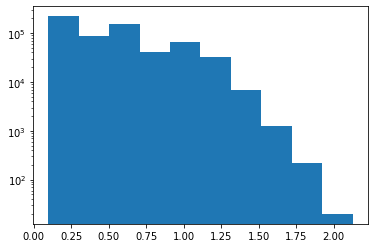

In [65]:
plt.yscale("log")
plt.hist(stratified2_pe_avg_p.pred_entropies.numpy(), bins=10)

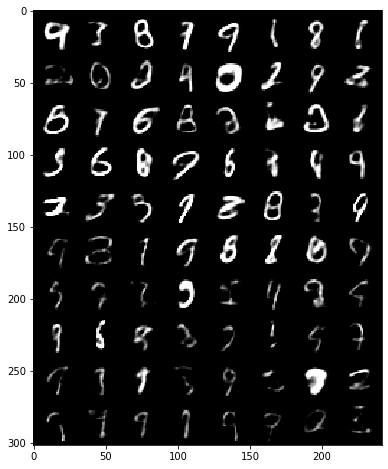

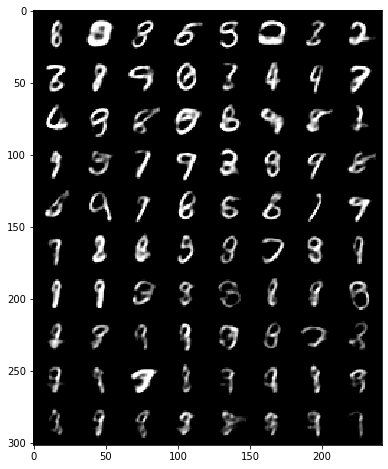

In [285]:
def show_stratified_samples(samples, pred_entropies, num_pe_bins, num_bin_samples, range=None):
    stratified_samples = []
    edges = np.histogram_bin_edges(pred_entropies, bins=num_pe_bins, range=range)
    for lower, upper in zip(edges[:-1], edges[1:]):
        bucket_mask = (pred_entropies >= lower) & (pred_entropies < upper)
        bucket_samples = samples[bucket_mask]
        sample_indices = np.random.choice(len(bucket_samples), size=num_bin_samples, replace=False)
        row_samples = bucket_samples[sample_indices]
        stratified_samples.append(row_samples)

    stratified_samples = torch.cat(stratified_samples)
    plt.figure(figsize=(num_pe_bins, num_bin_samples))
    show(
        make_grid(
            calibrated_post_process_vae_mnist(stratified_samples.view(-1, 1, 28, 28)),
            normalize=False,
            nrow=num_bin_samples,
        )
    )
    plt.show()


show_stratified_samples(stratified_ambiguous_samples, stratified_pe_avg_p.pred_entropies, 10, 8, range=[0, 1.6])
show_stratified_samples(stratified_ambiguous_samples2, stratified2_pe_avg_p.pred_entropies, 10, 8, range=[0, 1.6])

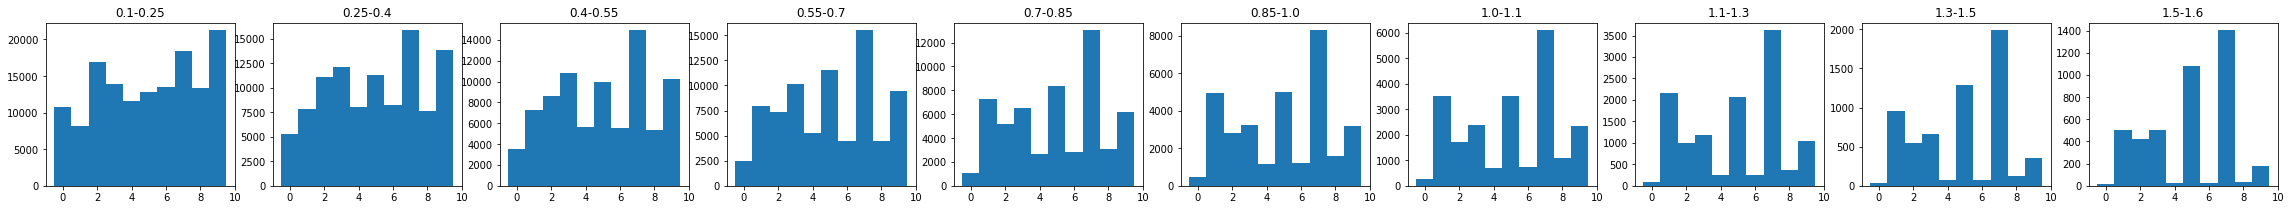

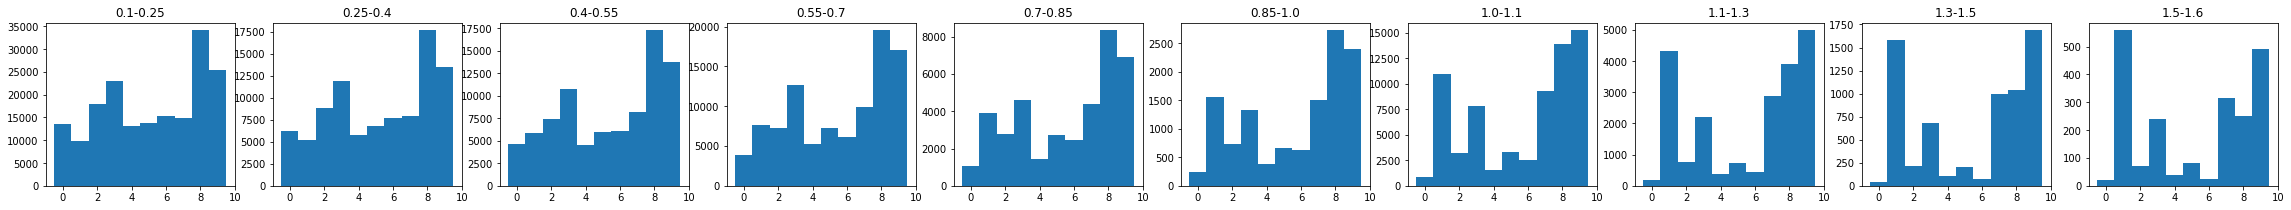

In [160]:
def show_label_buckets(entropies, labels, num_bins, range=None):
    edges = np.histogram_bin_edges(entropies.numpy(), bins=num_bins, range=range)

    plt.figure(figsize=(num_bins * 4, 3))
    for i, (lower, upper) in enumerate(zip(edges[:-1], edges[1:])):
        plt.subplot(1, num_bins, i + 1)
        bucket_labels = labels[(lower <= entropies) & (entropies < upper)]
        #plt.yscale("log")
        plt.title(f"{lower:.2}-{upper:.2}")
        plt.hist(bucket_labels.numpy(), bins=10, range=[-0.5, 9.5])

    plt.show()


show_label_buckets(stratified_pe_avg_p.pred_entropies, stratified_pe_avg_p.single_labels, 10, range=[0.1, 1.6])
show_label_buckets(stratified2_pe_avg_p.pred_entropies, stratified2_pe_avg_p.single_labels, 10, range=[0.1, 1.6])

(array([181243.,  91437.,  84499.,  96461.,  38645.,  12156.,  68766.,
         20767.,   6611.,   2091.]),
 array([0.1 , 0.25, 0.4 , 0.55, 0.7 , 0.85, 1.  , 1.15, 1.3 , 1.45, 1.6 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

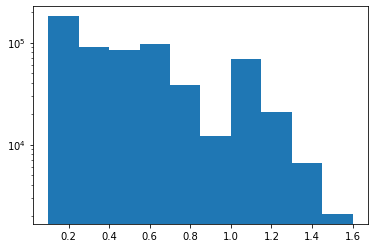

In [124]:
plt.yscale("log")
plt.hist(stratified2_pe_avg_p.pred_entropies.numpy(), bins=10, range=[0.1, 1.6])

<ipython-input-107-da7711c6186b>:10: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  h = plt.hist2d(


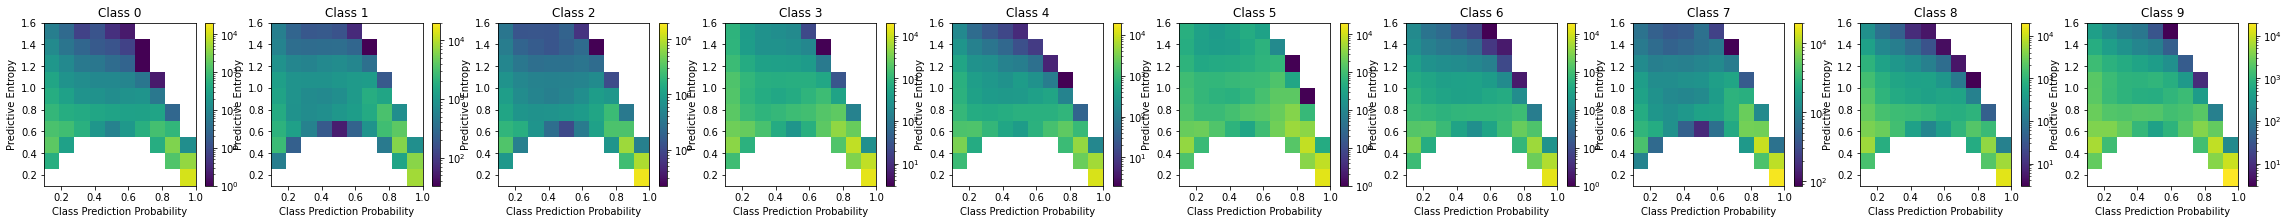

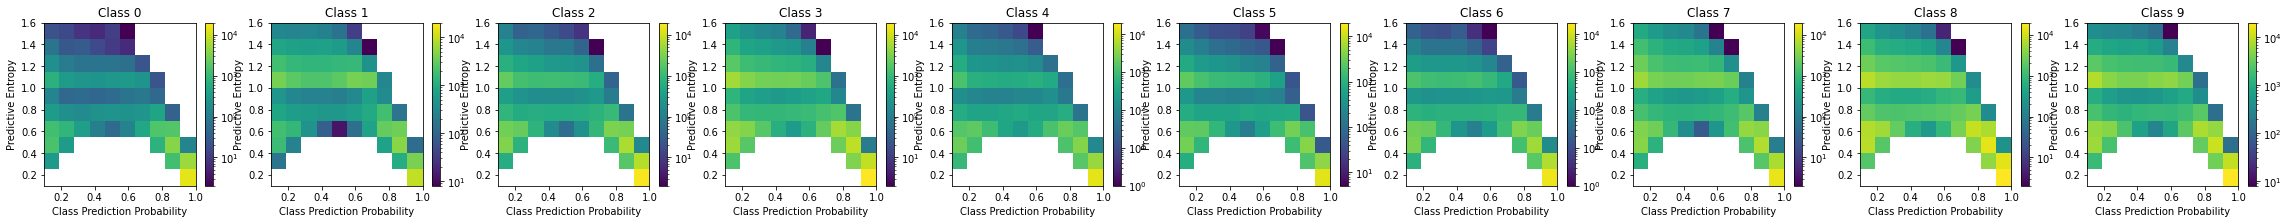

In [107]:
import matplotlib as mpl


def show_probs_vs_entropy(pemip: PeMiP, num_bins, entropy_range=None):
    entropies = pemip.pred_entropies
    predictions = pemip.predictions

    plt.figure(figsize=(num_bins * 4, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        h = plt.hist2d(
            predictions[:, i].numpy(),
            entropies.numpy(),
            bins=num_bins,
            norm=mpl.colors.LogNorm(),
            range=[[0.1, 1], entropy_range],
            vmax=2e4,
        )
        plt.xlabel("Class Prediction Probability")
        plt.ylabel("Predictive Entropy")
        plt.title(f"Class {i}")
        ax = plt.gca()
        plt.colorbar(h[-1], use_gridspec=True, ax=ax)


show_probs_vs_entropy(stratified_pe_avg_p, 10, entropy_range=[0.1, 1.6])
show_probs_vs_entropy(stratified2_pe_avg_p, 10, entropy_range=[0.1, 1.6])

To collect, 80k samples, we need 16k samples that we can then draw multiple labels from if we draw 5 labels per sample. This means about 1600 samples per bucket, assuming 10 buckets.

In [120]:
def entropy(p):
    nats = -p * torch.log(p)
    nats[torch.isnan(nats)] = 0.0
    entropy = torch.sum(nats, dim=-1)
    return entropy

In [211]:
def kl(p, q):
    items = -p * (torch.log(q) - torch.log(p))
    items[torch.isnan(items)] = 0.0
    kl = torch.sum(items, dim=-1)
    return kl

In [147]:
np.log(10)

2.302585092994046

In [151]:
%config Completer.use_jedi = False

## Fully Stochastic stratification

In [ ]:
max_samples = int(80e3)

entropies = stratified2_pe_avg_p.pred_entropies
predictions = stratified2_pe_avg_p.predictions

num_bins = 10
num_labels = 5
edges = np.histogram_bin_edges([], bins=num_bins, range=[0.1, 1.6])

num_stochastic_batches = 1024

stratified_indices = []

for lower, upper in tqdm(reversed(list(zip(edges[:-1], edges[1:])))):
    num_bucket_samples = max_samples // num_bins // num_labels
    prob_masses = torch.zeros(10)

    bucket_mask = (lower <= entropies) & (entropies < upper)
    bucket_indices = torch.nonzero(bucket_mask, as_tuple=False)[:,0]
    
    bucket_stochastic_batches = num_stochastic_batches * 181243 // len(bucket_indices)
    
    #plt.hist(entropies[bucket_indices].numpy(), bins=10, range=[0.1, 1.6])
    
    print(f"Sampling {num_bucket_samples} out of {len(bucket_indices)}")
    
    bucket_predictions = predictions[bucket_indices]
    bucket_avg_distribution = bucket_predictions.mean(dim=0)
    
    bucket_mean_dist = (bucket_predictions + bucket_avg_distribution[None, :]) / 2
    
    bucket_weights = torch.exp(kl(bucket_predictions, bucket_avg_distribution))
    

    # Draw batches with max_bucket_samples and pick the one with the highest entropy.
    # batch_indices = torch.stack([torch.as_tensor(
    #     np.random.choice(len(bucket_indices), (num_bucket_samples), replace=False)
    # ) for _ in tqdm(range(num_stochastic_batches))], dim=0)
    batch_indices = torch.cat([torch.as_tensor(
        torch.multinomial(bucket_weights.expand(32, len(bucket_indices)), num_samples=num_bucket_samples, replacement=False)
    ) for _ in tqdm(range(bucket_stochastic_batches//32))])
    #batch_indices = torch.multinomial(torch.ones((1, 1)).expand(num_stochastic_batches, len(bucket_indices)), num_samples=num_bucket_samples, replacement=False)
    
    bucket_stochastic_batches = batch_indices.shape[0]
    
    batch_indices_BNC = batch_indices.unsqueeze(2).expand((bucket_stochastic_batches, num_bucket_samples, 10))
    predictions_BNC = bucket_predictions.unsqueeze(0).expand((bucket_stochastic_batches, -1, 10))

    batch_prob_mass = torch.gather(predictions_BNC, index=batch_indices_BNC, dim=1).mean(dim=1)
    batch_entropy = entropy(batch_prob_mass)
    
    plt.title(lower)
    plt.hist(batch_entropy.numpy(), bins=10)
    plt.show()
    
    best_batch_entropy, best_batch = batch_entropy.max(dim=0)
    best_batch_indices = batch_indices[best_batch]

    print(best_batch_entropy)

    stratified_indices.append(bucket_indices[best_batch_indices])
    
    break
    
stratified_indices = torch.cat(stratified_indices)
len(stratified_indices)

## Path-Driven Stochastic Stratification

We start with an empty set in each bucket.

We pick a sample depending on how much it helps us achieve a uniform distribution.

We could use the KL between the sample's predictions and a uniform distribution:
$$ D_{KL}(p||U) = H(p||U) - H(p) = H(U) - H(p).$$
where $p$ is the average distribution after adding that sample.

$$p_\text{total}(p') = \frac{N p_0 + p'}{N+1}$$

We can draw samples from $p' \sim \exp (-D_{KL}(p_\text{total}(p')||U)/T)$.

\begin{align}
D_{KL}(p_\text{total}(p')||U) &= H(U) - H(p_\text{total}(p'))
\end{align}

In [272]:
@restore_or_create("doubly_stratified_indices.pt", recreate=False)
def bucket_stratify_indices():
    max_samples = int(80e3)

    entropies = stratified2_pe_avg_p.pred_entropies
    predictions = stratified2_pe_avg_p.predictions

    num_bins = 10
    num_labels = 10
    edges = np.histogram_bin_edges([], bins=num_bins, range=[0.1, 1.6])

    stratified_indices = []

    for lower, upper in tqdm(reversed(list(zip(edges[:-1], edges[1:])))):
        num_bucket_samples = max_samples // num_bins // num_labels
        prob_masses = torch.zeros(10)

        bucket_mask = (lower <= entropies) & (entropies < upper)
        bucket_indices = torch.nonzero(bucket_mask, as_tuple=False)[:,0]

        bucket_stochastic_batches = num_stochastic_batches * 181243 // len(bucket_indices)

        #plt.hist(entropies[bucket_indices].numpy(), bins=10, range=[0.1, 1.6])

        print(f"Sampling {num_bucket_samples} out of {len(bucket_indices)}")

        bucket_predictions = predictions[bucket_indices]

        bucket_mean_dist = (bucket_predictions + bucket_avg_distribution[None, :]) / 2

        batch_indices = []
        batch_candidates = list(range(len(bucket_indices)))

        for batch_size in tqdm(list(range(num_bucket_samples))):
            batch_sum_prediction = bucket_predictions[batch_indices].sum(dim=0).double()

            candidate_avg_predictions = (batch_sum_prediction + bucket_predictions[batch_candidates]) / (batch_size + 1)
            candidate_scores = np.log(10) - entropy(candidate_avg_predictions)

            tau = 1/(batch_size+1)**1.7
            if tau > 1e-4:
                candidate_weights = torch.exp(-candidate_scores/tau)
                try:
                    index = torch.multinomial(candidate_weights, num_samples=1, replacement=False)
                except:
                    print(tau)
                    raise                
            else:
                index = candidate_scores.argmin()

            winner = batch_candidates[index]
            winner_score = candidate_scores[index]
            batch_indices.append(winner)
            batch_candidates.remove(winner)        

        print(np.log(10)-winner_score)

        stratified_indices.append(bucket_indices[batch_indices])

    stratified_indices = torch.cat(stratified_indices)
    print(len(stratified_indices))
    return stratified_indices

doubly_stratified_indices = bucket_stratify_indices()

0it [00:00, ?it/s]

Sampling 800 out of 2091


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.2032, dtype=torch.float64)
Sampling 800 out of 6611


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.2934, dtype=torch.float64)
Sampling 800 out of 20767


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 68766


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 12156


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 38645


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 96461


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 84499


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 91437


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
Sampling 800 out of 181243


  0%|          | 0/800 [00:00<?, ?it/s]

tensor(2.3026, dtype=torch.float64)
8000


(array([804., 797., 799., 802., 799., 799., 795., 803., 798., 804.]),
 array([0.10105611, 0.25088114, 0.40070614, 0.55053115, 0.7003562 ,
        0.85018116, 1.0000062 , 1.1498312 , 1.2996562 , 1.4494812 ,
        1.5993062 ], dtype=float32),
 <BarContainer object of 10 artists>)

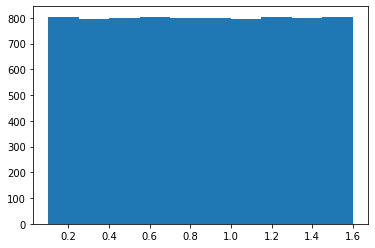

In [273]:
plt.hist(stratified2_pe_avg_p.pred_entropies[doubly_stratified_indices].numpy(), bins=10)

In [275]:
def show_prob_buckets(entropies, predictions, num_bins, entropy_range=None):
    edges = np.histogram_bin_edges(entropies.numpy(), bins=num_bins, range=entropy_range)

    plt.figure(figsize=(num_bins * 4, 3))
    for i, (lower, upper) in enumerate(zip(edges[:-1], edges[1:])):
        plt.subplot(1, num_bins, i + 1)
        bucket_prob_distribution = predictions[(lower <= entropies) & (entropies < upper)].mean(dim=0)
        print(entropy(bucket_prob_distribution))
        #plt.yscale("log")
        plt.title(f"{lower:.2}-{upper:.2}")
        plt.ylim(0,0.3)
        plt.bar(range(10), bucket_prob_distribution.numpy(), width=1)

    plt.show()

### Stratified probability distribution of each bucket

tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.3026)
tensor(2.2934)
tensor(2.2032)


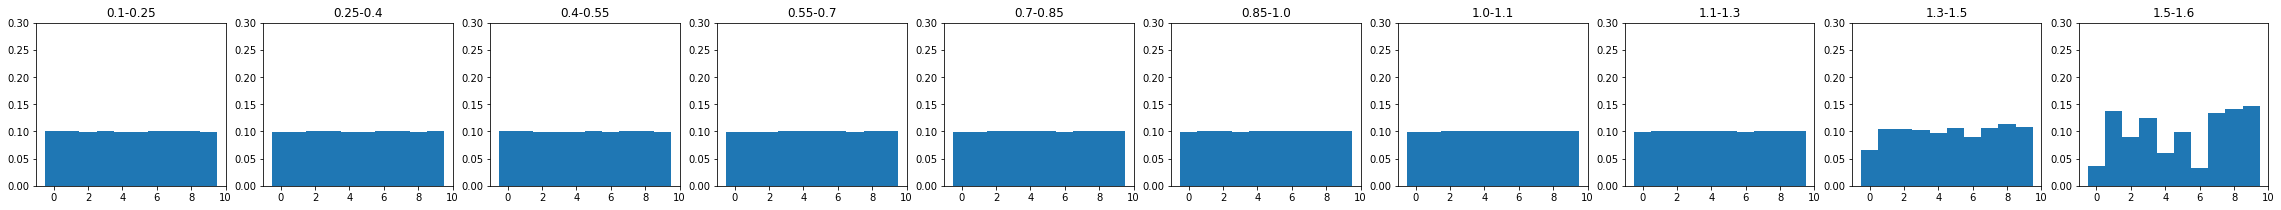

In [276]:
show_prob_buckets(stratified2_pe_avg_p.pred_entropies[doubly_stratified_indices], stratified2_pe_avg_p.predictions[doubly_stratified_indices], 10, entropy_range=[0.1, 1.6])

### Stratified probability distribution of the original samples

tensor(2.2333)
tensor(2.2221)
tensor(2.2009)
tensor(2.1835)
tensor(2.1561)
tensor(2.1111)
tensor(2.0603)
tensor(2.0037)
tensor(1.9769)
tensor(2.0107)


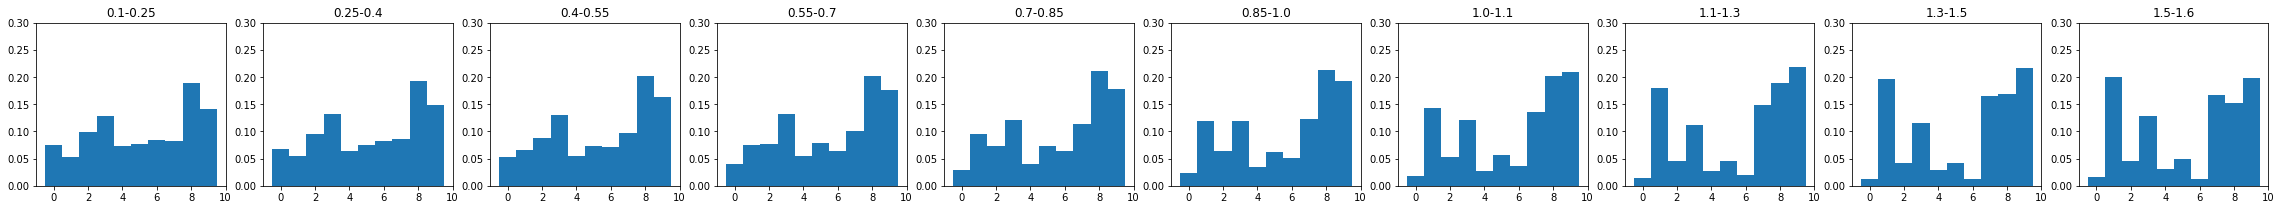

In [278]:
show_prob_buckets(stratified2_pe_avg_p.pred_entropies, stratified2_pe_avg_p.predictions, 10, entropy_range=[0.1, 1.6])

## Drawing labels

We will draw 10 labels for each sample.

In [282]:
def draw_labels(predictions, num_labels):
    drawn_labels = torch.multinomial(predictions, num_samples=num_labels, replacement=True)
    return drawn_labels    

amnist_predictions = stratified2_pe_avg_p.predictions[doubly_stratified_indices]
amnist_labels = draw_labels(amnist_predictions, 10)

In [284]:
amnist_samples = stratified_ambiguous_samples2[doubly_stratified_indices]
amnist_calibrated_samples = calibrated_post_process_vae_mnist(amnist_samples)

---

In [30]:
# Calibrate post-processing
uncalibrated_ambig_pred_entropies = []
with torch.no_grad():
    for decoded_image_batch in tqdm(torch.split(ambig_decoded_images, 4096)):
        lenet_pre_softmaxs = [lenet(decoded_image_batch.cuda()) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        uncalibrated_ambig_pred_entropies.append(batch_pred_entropies.cpu())

uncalibrated_ambig_pred_entropies = torch.cat(uncalibrated_ambig_pred_entropies)

  0%|          | 0/147 [00:00<?, ?it/s]

In [31]:
mnist_in_amnist = ambig_decoded_images[uncalibrated_ambig_pred_entropies < 0.1]
print(len(mnist_in_amnist) / len(ambig_decoded_images))

0.0444651963464098


In [32]:
# compute a histogram for MNIST
num_histogram_bins = 20
mnist_train_histogram = np.histogram(mnist_train_loader.dataset.data.numpy(), bins=num_histogram_bins)
mnist_train_histogram = (
    mnist_train_histogram[0] / mnist_train_loader.dataset.data.numel(),
    mnist_train_histogram[1] / 255.0,
)
print(mnist_train_histogram)

(array([0.81766473, 0.00818261, 0.00677455, 0.00538276, 0.00559016,
       0.00534005, 0.00515952, 0.00415232, 0.00496624, 0.00452874,
       0.00600338, 0.0046942 , 0.00468999, 0.00529315, 0.00565223,
       0.00537504, 0.00601399, 0.00699324, 0.00853648, 0.07900661]), array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))


<BarContainer object of 20 artists>

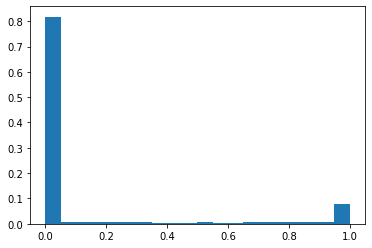

In [33]:
plt.bar(mnist_train_histogram[1][:-1], mnist_train_histogram[0], align="edge", width=0.05)

In [34]:
mnist_in_amnist_mean = torch.mean(mnist_in_amnist)
mnist_in_amnist_std = torch.std(mnist_in_amnist)
print(mnist_in_amnist_mean, mnist_in_amnist_std)

mnist_in_amnist_min, mnist_in_amnist_max = mnist_in_amnist.min(), mnist_in_amnist.max()
print(mnist_in_amnist_min, mnist_in_amnist_max)

tensor(-0.0803) tensor(0.7815)
tensor(-0.4242) tensor(2.8215)


(array([0.8320308 , 0.01013573, 0.00835178, 0.00731693, 0.00668561,
       0.00617531, 0.00583022, 0.00554599, 0.00539756, 0.00520209,
       0.00508031, 0.00496343, 0.00490647, 0.00478178, 0.00478412,
       0.0047191 , 0.00469031, 0.00469065, 0.00473135, 0.06398047]), array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
      dtype=float32))


<BarContainer object of 20 artists>

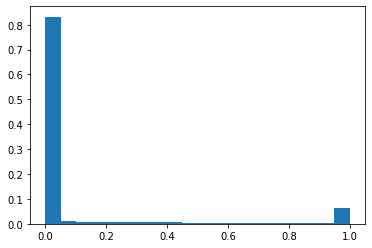

In [35]:
mnist_in_amnist_histogram = np.histogram(
    calibrated_post_process_amnist(mnist_in_amnist).cpu().numpy(), bins=num_histogram_bins, range=[0, 1]
)
mnist_in_amnist_histogram = mnist_in_amnist_histogram[0] / mnist_in_amnist.numel(), mnist_in_amnist_histogram[1]
print(mnist_in_amnist_histogram)
plt.bar(
    mnist_in_amnist_histogram[1][:-1],
    mnist_in_amnist_histogram[0],
    align="edge",
    width=mnist_in_amnist_histogram[1][1] - mnist_in_amnist_histogram[1][0],
)

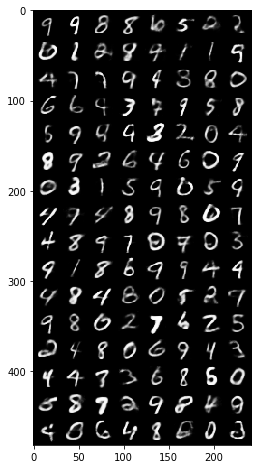

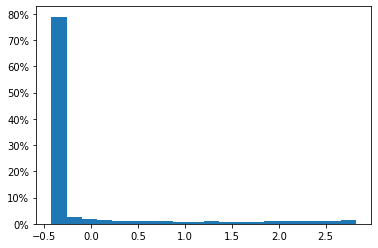

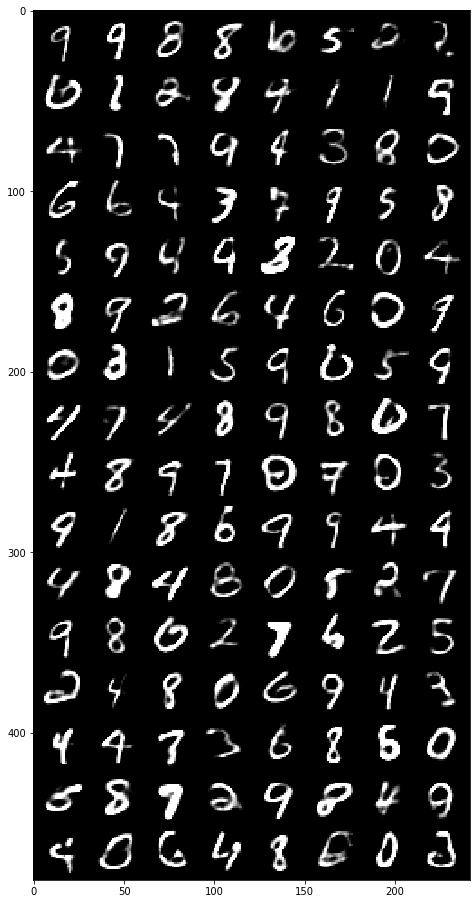

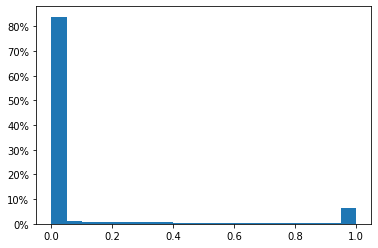

In [36]:
plt.figure(figsize=(8, 8))
samples = mnist_in_amnist[: 128 * 31 : 31].view(128, 1, 28, 28)
show(make_grid(samples, normalize=True, scale_each=False))
plt.show()
plt.hist(samples.cpu().flatten().numpy(), bins=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=unwhitened.numel()))
plt.show()

plt.figure(figsize=(8, 16))
whitened = calibrated_post_process_amnist(samples)
show(make_grid(whitened, normalize=False, scale_each=False))
plt.show()
plt.hist(whitened.cpu().flatten().numpy(), bins=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=whitened.numel()))
plt.show()

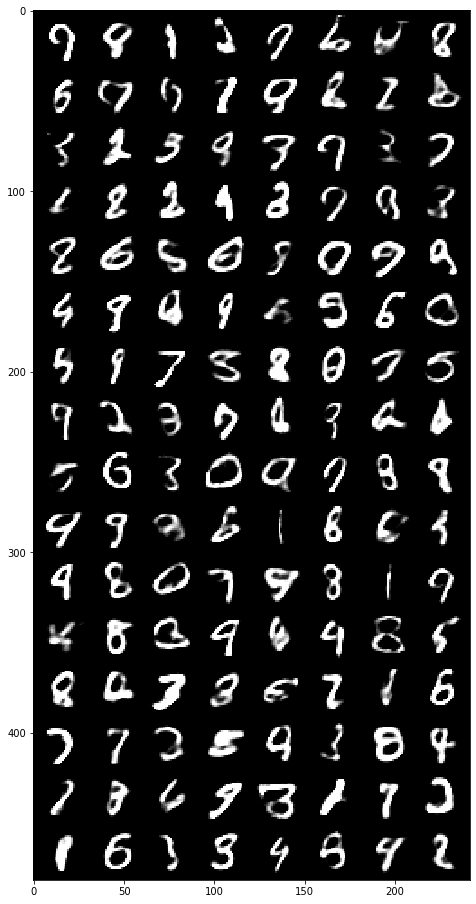

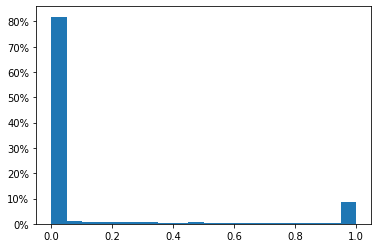

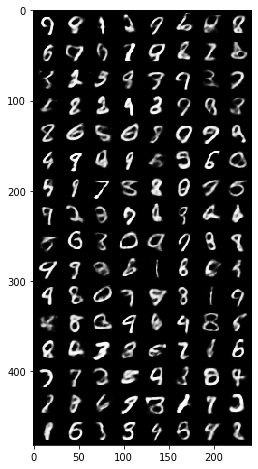

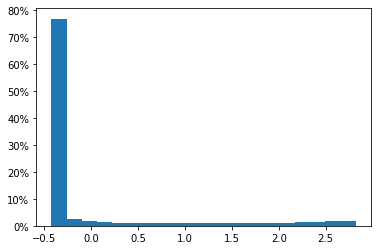

In [37]:
plt.figure(figsize=(8, 16))
samples = calibrated_post_process_amnist(
    ambig_decoded_images[uncalibrated_ambig_pred_entropies > 0.1][: 128 * 11 : 11].view(128, 1, 28, 28)
)
show(make_grid(samples, normalize=False, scale_each=False))
plt.show()
plt.hist(samples.cpu().flatten().numpy(), bins=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=unwhitened.numel()))
plt.show()
plt.figure(figsize=(8, 8))
samples = ambig_decoded_images[uncalibrated_ambig_pred_entropies > 0.1][: 128 * 11 : 11].view(128, 1, 28, 28)
show(make_grid(samples, normalize=True, scale_each=False))
plt.show()
plt.hist(samples.cpu().flatten().numpy(), bins=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=unwhitened.numel()))
plt.show()

In [54]:
@restore_or_create("calibrated_ambig_decoded_images.pt", recreate=False)
def calibrate_samples():
    return calibrated_post_process_amnist(ambig_decoded_images)


calibrated_ambig_decoded_images = calibrate_samples()

In [55]:
@restore_or_create("ambig_entropies_etc.pt", recreate=False)
@torch.no_grad()
def compute_pe_mi_avg():
    ambig_pred_entropies = []
    ambig_avg_entropies = []
    ambig_predictions = []

    for decoded_image_batch in tqdm(torch.split(calibrated_ambig_decoded_images, 512)):
        lenet_pre_softmaxs = [lenet(whiten_mnist(decoded_image_batch.cuda())) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)

        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)

        ambig_pred_entropies.append(batch_pred_entropies.cpu())
        ambig_avg_entropies.append(batch_avg_entropies.cpu())
        lenet_pre_softmaxs = torch.transpose(lenet_pre_softmaxs, 0, 1)  # swap MC samples with batch dims
        ambig_predictions.append(lenet_pre_softmaxs.cpu())

    ambig_pred_entropies = torch.cat(ambig_pred_entropies).cpu()
    ambig_avg_entropies = torch.cat(ambig_avg_entropies).cpu()
    ambig_predictions = torch.cat(ambig_predictions).cpu()

    return ambig_pred_entropies, ambig_avg_entropies, ambig_predictions


ambig_pred_entropies, ambig_avg_entropies, ambig_predictions = compute_pe_mi_avg()

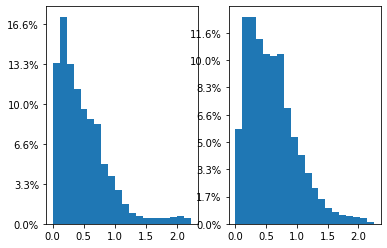

In [56]:
plt.subplot(1, 2, 1)
plt.hist(ambig_pred_entropies.numpy(), bins=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=ambig_pred_entropies.numel()))
plt.subplot(1, 2, 2)
plt.hist(uncalibrated_ambig_pred_entropies.numpy(), bins=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=uncalibrated_ambig_pred_entropies.numel()))
plt.show()

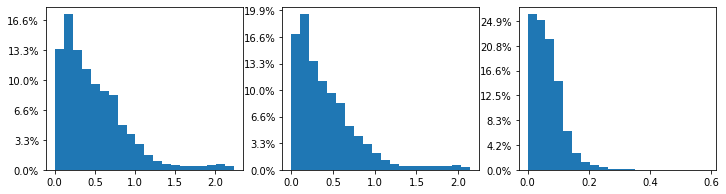

In [57]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.hist(ambig_pred_entropies.numpy(), bins=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=ambig_pred_entropies.numel()))
plt.subplot(1, 3, 2)
plt.hist(ambig_avg_entropies.numpy(), bins=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=ambig_avg_entropies.numel()))
plt.subplot(1, 3, 3)
plt.hist((ambig_pred_entropies - ambig_avg_entropies).numpy(), bins=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=ambig_avg_entropies.numel()))

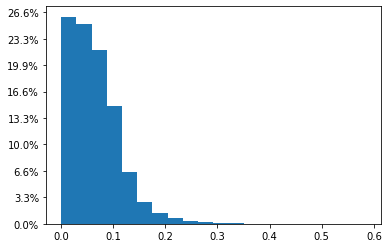

In [58]:
MI = ambig_pred_entropies - ambig_avg_entropies
plt.hist(MI.numpy(), 20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=ambig_avg_entropies.numel()))
# sorted_MI, original_indices = torch.sort(MI)

In [59]:
# in dist indices (well, not OoD)
ambiguous_id_ind = (MI < 0.1) & (ambig_pred_entropies > 0.1)
ambiguous_id_ind.sum() / len(ambiguous_id_ind)

tensor(0.6947)

In [60]:
ambiguous_id_ind.sum()

tensor(418062)

(array([179520., 101714.,  62248.,  35245.,  19037.,   6906.,   3584.,
          2770.,   2963.,   4075.]),
 array([0.10000068, 0.31285638, 0.5257121 , 0.73856777, 0.95142347,
        1.1642791 , 1.3771348 , 1.5899905 , 1.8028462 , 2.015702  ,
        2.2285576 ], dtype=float32),
 <BarContainer object of 10 artists>)

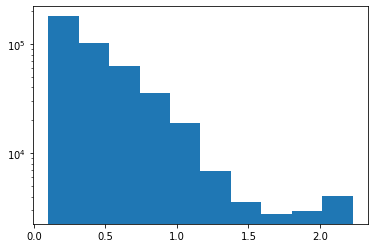

In [61]:
plt.yscale("log")
plt.hist(ambig_pred_entropies[ambiguous_id_ind].numpy(), bins=10)

In [62]:
counts, bins = np.histogram(ambig_pred_entropies[ambiguous_id_ind].numpy(), bins=10)
counts, bins

(array([179520, 101714,  62248,  35245,  19037,   6906,   3584,   2770,
          2963,   4075]),
 array([0.10000068, 0.31285638, 0.5257121 , 0.73856777, 0.95142347,
        1.1642791 , 1.3771348 , 1.5899905 , 1.8028462 , 2.015702  ,
        2.2285576 ], dtype=float32))

In [63]:
counts * (np.exp(bins[:-1]) + 1)

array([377920.42007446, 240790.12616825, 167550.64009285, 109010.52229047,
        68331.27264619,  29030.14673424,  17789.28833008,  16353.25525761,
        20939.19578028,  34661.92879677])

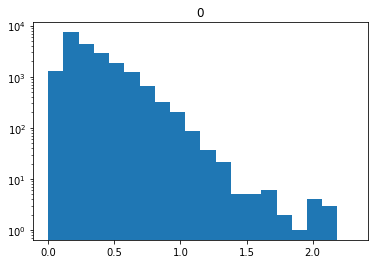

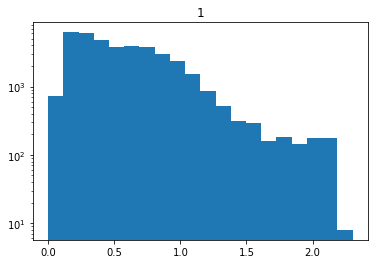

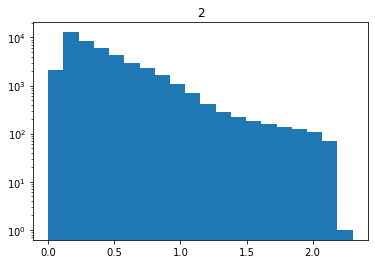

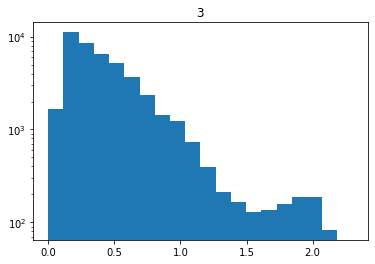

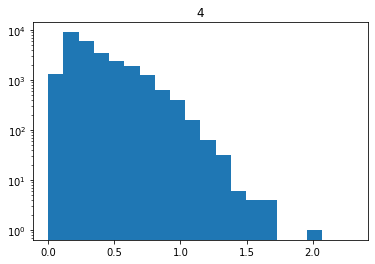

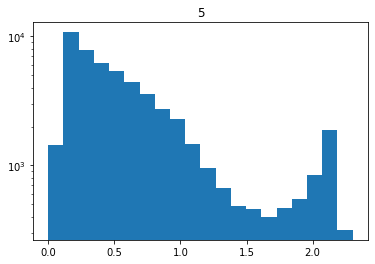

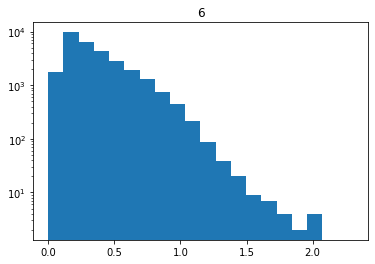

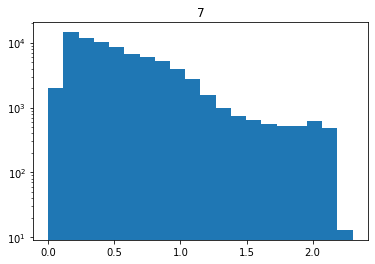

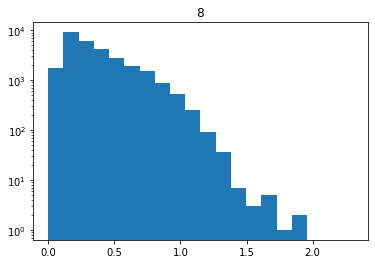

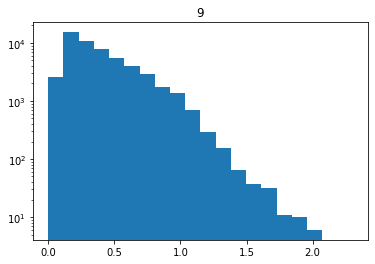

<Figure size 432x288 with 0 Axes>

In [64]:
pred_labels = F.softmax(ambig_predictions[ambiguous_id_ind], dim=-1).mean(dim=1).argmax(-1)

mass_at_high_ent = []
for i in range(10):
    label_entropies = ambig_pred_entropies[ambiguous_id_ind][pred_labels == i]
    # mass_at_high_ent += [(tmp > 0.6).sum().numpy()]
    mass_at_high_ent.append(label_entropies.max())
    # print(tmp.shape)
    plt.title(i)
    plt.hist(label_entropies.cpu().numpy(), bins=20, range=[0, np.log(10)])
    plt.yscale("log")
    plt.figure()

We need to stratify the samples, so that we have a good coverage of different entropies and different labels.

AMNIST will contain multiple labels for the same sample. We want to draw $\exp (H[Y|x] + 1)$ labels for a sample x.

In [65]:
import matplotlib as mpl

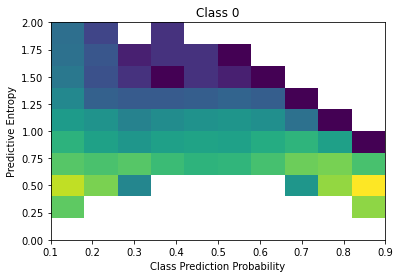

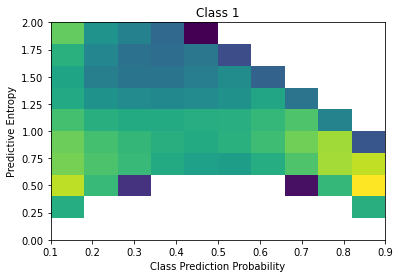

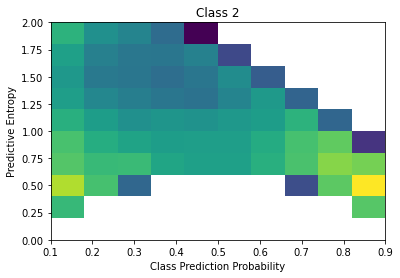

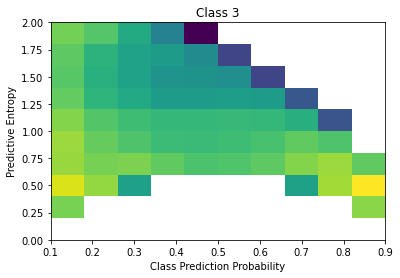

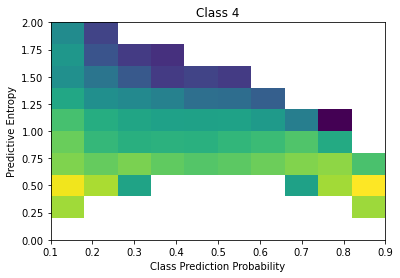

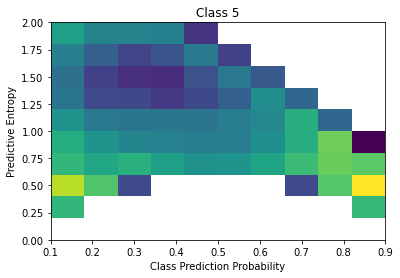

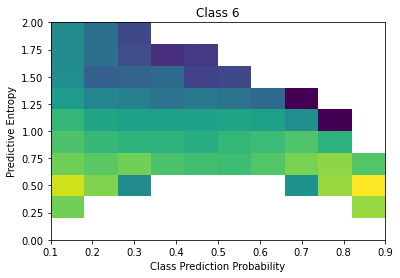

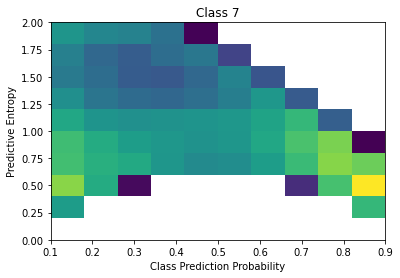

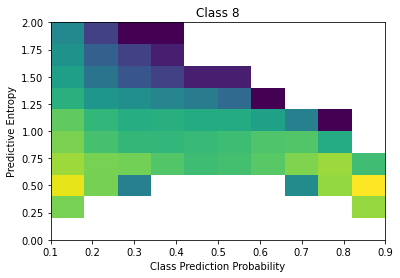

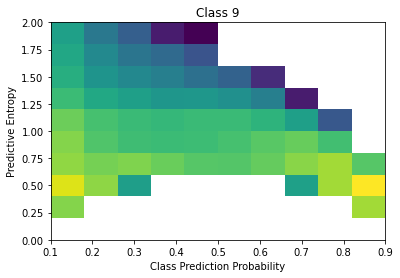

<Figure size 432x288 with 0 Axes>

In [66]:
import matplotlib as mpl

id_ambig_pred_entropies = ambig_pred_entropies[ambiguous_id_ind]
ensemble_predictions = F.softmax(ambig_predictions[ambiguous_id_ind], dim=-1).mean(dim=1)

for i in range(10):
    plt.hist2d(
        ensemble_predictions[:, i].numpy(),
        id_ambig_pred_entropies.numpy(),
        bins=10,
        norm=mpl.colors.LogNorm(),
        range=[[0.1, 0.9], [0, 2]],
    )
    plt.xlabel("Class Prediction Probability")
    plt.ylabel("Predictive Entropy")
    plt.title(f"Class {i}")
    plt.figure()

Visualize samples from each PE bucket.


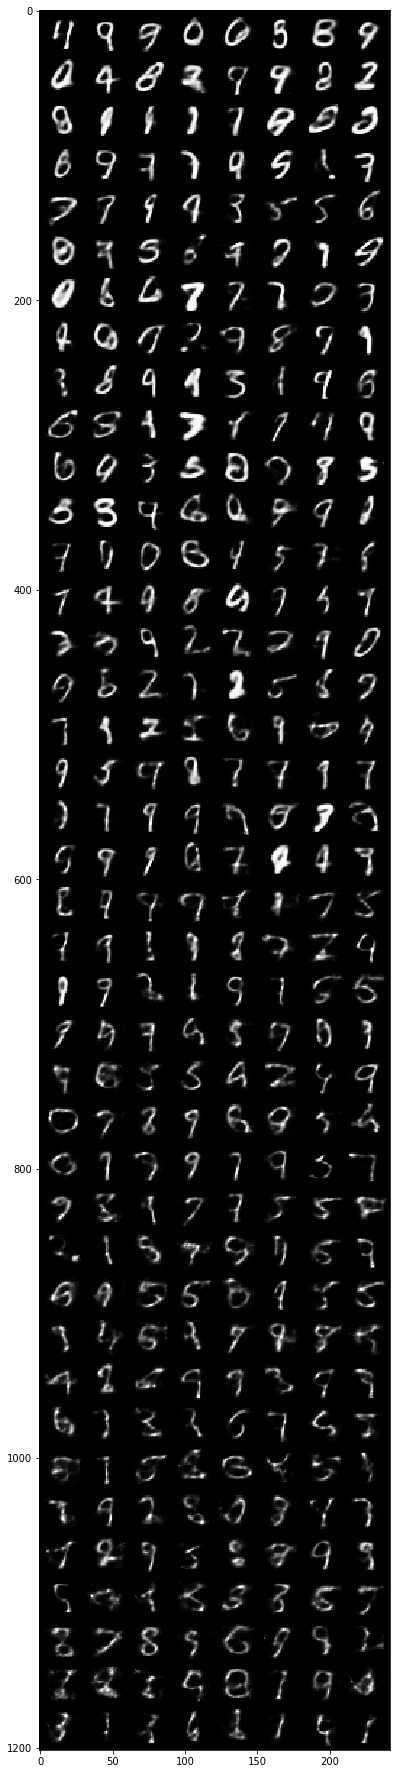

In [74]:
stratified_samples = []
row_size = 16
edges = np.histogram_bin_edges(id_ambig_pred_entropies, bins=20)
for lower, upper in zip(edges[:-1], edges[1:]):
    bucket_mask = ambiguous_id_ind & (ambig_pred_entropies >= lower) & (ambig_pred_entropies < upper)
    bucket_samples = ambig_decoded_images[bucket_mask]
    sample_indices = np.random.choice(len(bucket_samples), size=row_size, replace=False)
    row_samples = bucket_samples[sample_indices]
    stratified_samples.append(row_samples)

stratified_samples = torch.cat(stratified_samples)
plt.figure(figsize=(40, 32))
show(make_grid(stratified_samples.view(-1, 1, 28, 28), normalize=True, scale_each=True))

In [210]:
# least to highest mass at high entropy
arr = np.argsort(mass_at_high_ent)
arr

array([8, 0, 4, 9, 6, 2, 1, 7, 3, 5])

In [205]:
# mass we want these in our dataset
duplicates = 5 * [8] + 3 * [16]  # nice but low mass at high ent

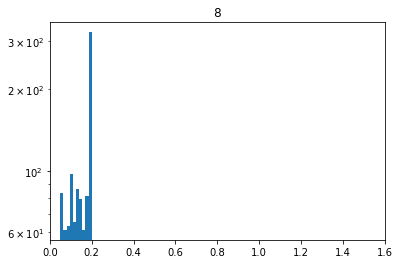

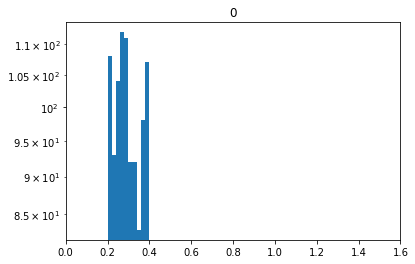

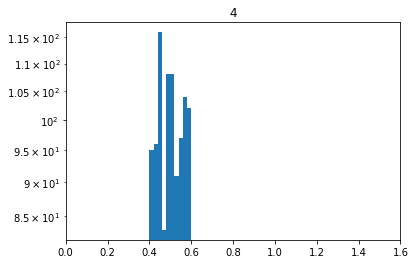

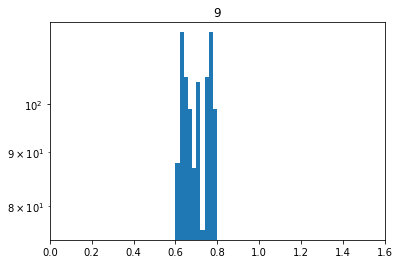

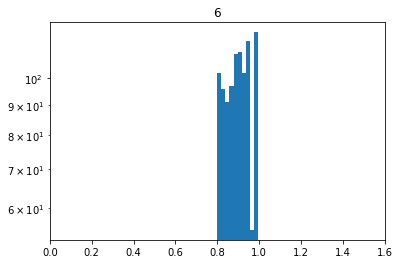

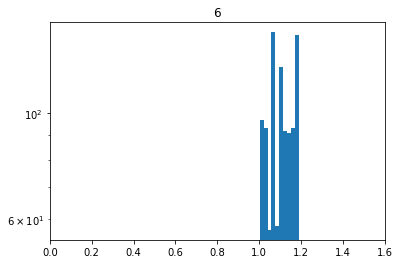

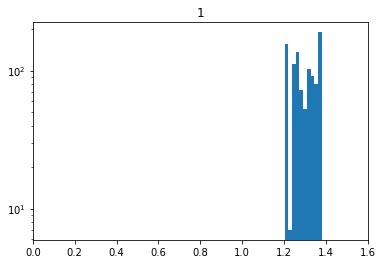

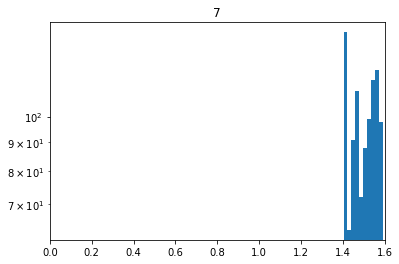

In [215]:
num_amb_examples = 1000
div_by = 5
new_data, new_labels = [], []
ambig_pred_entropies_id = ambig_pred_entropies[ambiguous_id_ind]
softmax_predictions = F.softmax(ambig_predictions[ambiguous_id_ind, 0], dim=-1)
_, sorted_labels = torch.sort(softmax_predictions, descending=True)  # sort labels per point
buckets = 8
arr = np.concatenate([arr[: buckets - 3], arr[-4:-1]])  # we want to make sure we have enough mass at high ent
for ind in range(0, buckets):
    label_ind = sorted_labels[:, 0] == arr[ind]  # get all indices of points with top label == ind
    label_ents = ambig_pred_entropies_id[label_ind]
    ent_from_ind = label_ents < (ind + 1) / div_by
    ent_to_ind = label_ents[ent_from_ind] >= ind / div_by

    # stratisfy:
    label_ents_in_range = label_ents[ent_from_ind][ent_to_ind]
    if len(label_ents_in_range) == 0:
        from IPython.core.debugger import set_trace

        set_trace()
        print("break")
        break

    sorted_entropies, original_indices = torch.sort(label_ents_in_range)
    uniform_draws = torch.rand(num_amb_examples) / div_by + ind / div_by
    drawn_indices = torch.searchsorted(sorted_entropies, uniform_draws)
    stratified_indices = original_indices[drawn_indices - 1]

    plt.figure()
    plt.yscale("log")
    plt.title(arr[ind])
    plt.xlim(0, buckets * 1.0 / div_by)
    plt.hist(label_ents_in_range[stratified_indices].numpy())
    ps = softmax_predictions[label_ind][ent_from_ind][ent_to_ind][stratified_indices]
    ims = ambig_decoded_images[ambiguous_id_ind][label_ind][ent_from_ind][ent_to_ind][stratified_indices]
    d = duplicates[ind]

    for i in range(num_amb_examples):
        new_data += d * [ims[i]]
        new_labels += list(np.random.choice(10, d, p=ps[i].numpy()))

In [216]:
len(new_data)

88000

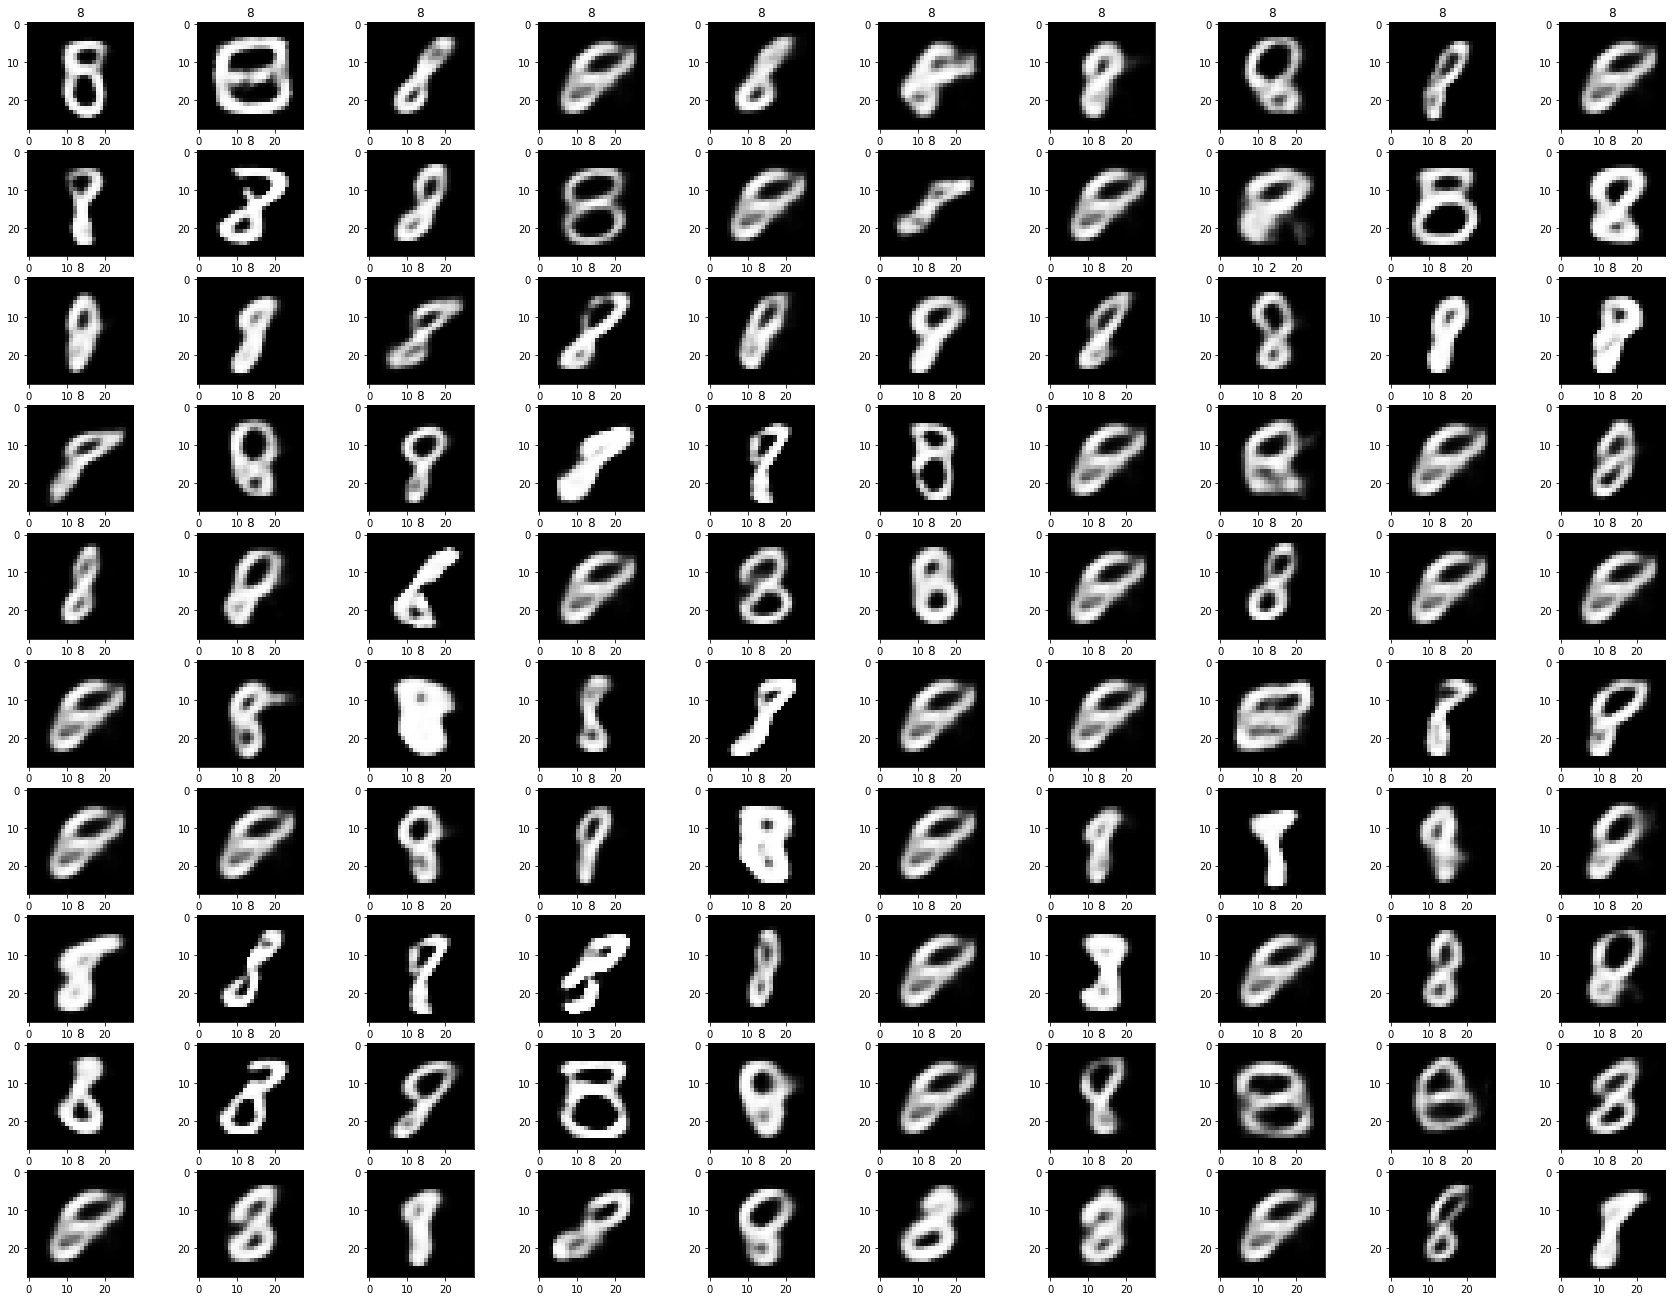

In [219]:
# Visualize some samples

il = list(range(10))
jl = list(range(10))
plt.figure(figsize=(len(il) * 3, len(jl) * 3 / 1.3))
for i in il:
    for j in jl:
        index = j * len(il) + i
        plt.subplot(len(jl), len(il), index + 1)
        # plt.imshow(ambiguous_mnist_digits[index, 0].numpy(), cmap='gray')
        plt.imshow(new_data[80 * index][0].numpy(), cmap="gray")
        # plt.title(int(amibguous_mnist_entropy[index].item()*10000)/10000)
        plt.title(new_labels[80 * index])

plt.show()

(array([ 9341., 12622.,  2993.,  1187.,  8399.,  4933., 16425., 13874.,
         9822.,  8404.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

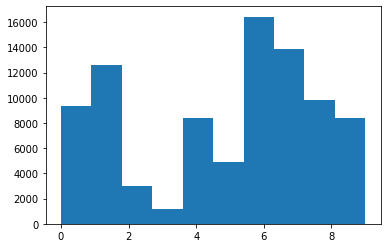

In [213]:
plt.hist(new_labels)

In [432]:
final_amnist_data = torch.stack(new_data)
final_amnist_labels = np.stack(new_labels)
final_amnist_data.shape, final_amnist_labels.shape

(torch.Size([88000, 1, 28, 28]), (88000,))

In [32]:
shuffle = torch.randperm(final_amnist_data.shape[0])
torch.save(final_amnist_data[shuffle], "amnist_data.pt")
torch.save(final_amnist_labels[shuffle], "amnist_labels.pt")

In [433]:
from torch.utils.data import ConcatDataset, TensorDataset

In [34]:
# Zipping and storing the file
import zipfile

zipObj = zipfile.ZipFile("res.zip", "w")

zipObj.write("amnist_data.pt")
zipObj.write("amnist_labels.pt")

zipObj.close()

In [35]:
import shutil
import zipfile

with zipfile.ZipFile("res.zip", "r") as zip_ref:
    zip_ref.extractall(".")

!ls '.' -lah

total 1.2G
drwxrwxr-x 5 jishnu jishnu 4.0K Mar 18 15:19 .
drwxrwxr-x 4 jishnu jishnu 4.0K Mar 16 23:07 ..
-rw-rw-r-- 1 jishnu jishnu 782K Mar 18 15:19 ambig_avg_entropies.pt
-rw-rw-r-- 1 jishnu jishnu 599M Mar 18 15:19 ambig_decoded_images.pt
-rw-rw-r-- 1 jishnu jishnu 782K Mar 18 15:19 ambig_pred_entropies.pt
-rw-rw-r-- 1 jishnu jishnu  39M Mar 18 15:19 ambig_predictions.pt
-rw-rw-r-- 1 jishnu jishnu  974 Mar 16 18:15 ambiguous_mnist_dataset.py
-rw-rw-r-- 1 jishnu jishnu  581 Mar 16 21:45 ambiguous_mnist.py
-rw-rw-r-- 1 jishnu jishnu 264M Mar 18 15:21 amnist_data.pt
-rw-rw-r-- 1 jishnu jishnu 689K Mar 18 15:21 amnist_labels.pt
drwxrwxr-x 4 jishnu jishnu 4.0K Mar 16 22:24 data
-rw-rw-r-- 1 jishnu jishnu 177K Mar 16 22:29 dmnist_lenet.model
-rw-rw-r-- 1 jishnu jishnu    0 Mar 15 08:55 __init__.py
drwxrwxr-x 2 jishnu jishnu 4.0K Mar 15 09:10 .ipynb_checkpoints
-rw-rw-r-- 1 jishnu jishnu 177K Mar 16 13:17 lenet0.model
-rw-rw-r-- 1 jishnu jishnu 177K Mar 16 13:20 lenet1.model
-rw-rw-r-- 1 

# Train DMnist-LeNet

In [36]:
import data.ambiguous_mnist.ambiguous_mnist as ambiguous_mnist
import data.dirty_mnist as dirty_mnist
import data.fashion_mnist as fashion_mnist
import data.mnist as mnist

In [37]:
!pwd

/home/jishnu/Projects/OATML/DDU/cleaned_code_2/data/ambiguous_mnist


In [38]:
mnist_test_loader = mnist.get_test_loader(bs)
amnist_test_loader = ambiguous_mnist.get_loaders(".", batch_size=bs, train=False)
dmnist_test_loader = dirty_mnist.get_test_loader(".", batch_size=bs)
dmnist_train_loader, _ = dirty_mnist.get_train_valid_loader(".", batch_size=bs, valid_size=0)

In [39]:
from data import fashion_mnist

fmnist_test_loader = fashion_mnist.get_loaders(bs, train=False)
fmnist_train_loader = fashion_mnist.get_loaders(bs, train=True)

In [40]:
dmnist_lenet = LeNet(num_classes=10).cuda()
dmnist_optimizer = optim.Adam(dmnist_lenet.parameters())

In [41]:
best_loss = None
best_epoch = None
for epoch in tqdm(range(1, 10)):
    train(epoch, dmnist_train_loader, dmnist_optimizer, dmnist_lenet)
    test_loss = test(dmnist_test_loader, dmnist_lenet)
    if not best_loss or best_loss > test_loss:
        torch.save(dmnist_lenet.state_dict(), "./dmnist_lenet.model")
        best_loss = test_loss
        best_epoch = epoch
        print("New best model", best_epoch, " with ", best_loss)

print("Best epoch", best_epoch)

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 1 [0/120000 (0%)]	Loss: 0.022960
Train Epoch: 1 [10000/120000 (8%)]	Loss: 0.003751
Train Epoch: 1 [20000/120000 (17%)]	Loss: 0.004081
Train Epoch: 1 [30000/120000 (25%)]	Loss: 0.004241
Train Epoch: 1 [40000/120000 (33%)]	Loss: 0.004834
Train Epoch: 1 [50000/120000 (42%)]	Loss: 0.003639
Train Epoch: 1 [60000/120000 (50%)]	Loss: 0.004305
Train Epoch: 1 [70000/120000 (58%)]	Loss: 0.004532
Train Epoch: 1 [80000/120000 (67%)]	Loss: 0.002763
Train Epoch: 1 [90000/120000 (75%)]	Loss: 0.004771
Train Epoch: 1 [100000/120000 (83%)]	Loss: 0.003051
Train Epoch: 1 [110000/120000 (92%)]	Loss: 0.005576
====> Epoch: 1 Average loss: 0.0049
====> Test set loss: 0.0036
New best model 1  with  0.0035933565802872183
Train Epoch: 2 [0/120000 (0%)]	Loss: 0.005285
Train Epoch: 2 [10000/120000 (8%)]	Loss: 0.001948
Train Epoch: 2 [20000/120000 (17%)]	Loss: 0.005443
Train Epoch: 2 [30000/120000 (25%)]	Loss: 0.003064
Train Epoch: 2 [40000/120000 (33%)]	Loss: 0.003767
Train Epoch: 2 [50000/120000 (42%

In [42]:
dmnist_lenet.load_state_dict(torch.load("./dmnist_lenet.model"))

<All keys matched successfully>

In [44]:
from metrics.classification_metrics import test_classification_net

device = torch.device("cuda")
conf_matrix, acc, labels, predictions, confidences = test_classification_net(dmnist_lenet, test_loader, device)
print(conf_matrix)
print("Accuracy: " + str(acc))

[[ 977    0    0    0    0    0    0    1    2    0]
 [   0 1103    0    4    0    1    2    1   24    0]
 [   6    0  994    3    2    0    2    2   23    0]
 [   0    0    0  971    0   28    0    1    7    3]
 [   1    0    0    0  960    0    1    0    5   15]
 [   1    0    0    1    0  886    1    0    2    1]
 [  15    1    0    0    1    2  929    0   10    0]
 [   1    0    6    6    1    0    0 1003    7    4]
 [   2    0    0    1    0    0    0    0  969    2]
 [   1    0    0    0    1    5    0    1   12  989]]
Accuracy: 0.9781


In [45]:
def evaluate(test_loader, lenet):
    lenet.eval()
    test_loss = 0
    labels = []
    predictions = []
    with torch.no_grad():
        for data, label in tqdm(test_loader):
            data = data.cuda()
            label = label.cuda()
            out = lenet(data)
            predictions.append(out)
            labels.append(label)

    labels = torch.cat(labels)
    predictions = torch.cat(predictions)
    return predictions, labels

In [46]:
dmnist_test_predictions, _ = evaluate(dmnist_test_loader, dmnist_lenet)
amnist_test_predictions, amnist_test_labels = evaluate(amnist_test_loader, dmnist_lenet)
mnist_test_predictions, _ = evaluate(mnist_test_loader, dmnist_lenet)
fmnist_test_predictions, _ = evaluate(fmnist_test_loader, dmnist_lenet)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
def cat_entropy(pre_softmax):
    logits = F.log_softmax(pre_softmax, dim=-1)
    nats = -logits * logits.exp()
    return nats.sum(dim=-1)


def plot_entropies(p, **kwargs):
    entropies = cat_entropy(p)
    plt.hist(entropies.cpu().numpy(), **kwargs)


# plot_entropies(amnist_test_predictions, alpha=0.8, label="AMNIST")
# plot_entropies(mnist_test_predictions, alpha=0.8, label="MNIST")
# plot_entropies(fmnist_test_predictions, alpha=0.8, label="FMNIST")
# plt.legend()

In [48]:
ents = cat_entropy(amnist_test_predictions)
# low_ent = ents < 0.35
# plt.hist(ents[low_ent].cpu().numpy())

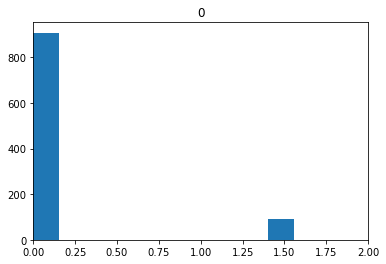

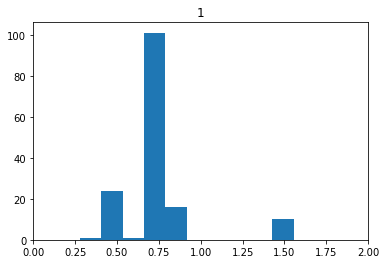

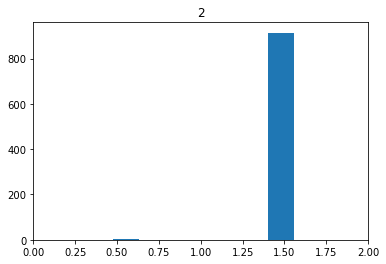

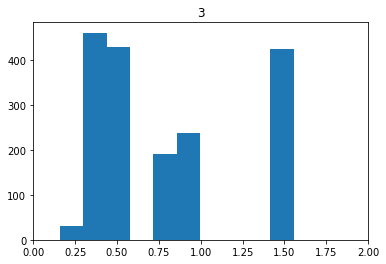

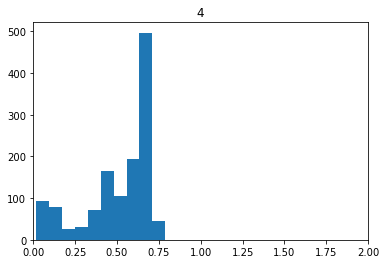

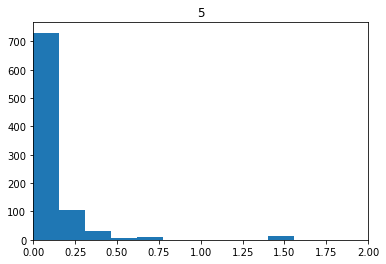

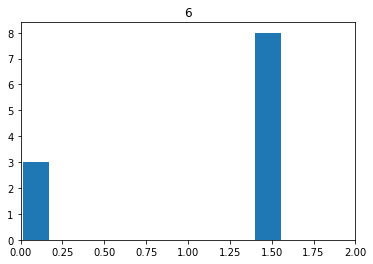

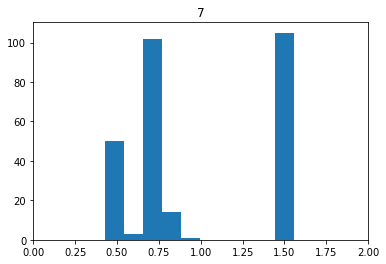

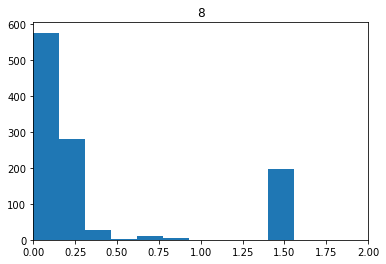

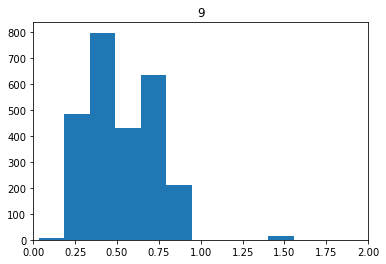

<Figure size 432x288 with 0 Axes>

In [49]:
for i in range(10):
    tmp = ents[amnist_test_labels == i]
    # print(tmp)
    plt.title(i)
    plt.hist(tmp.cpu().numpy())
    plt.xlim(0, 2)
    plt.figure()

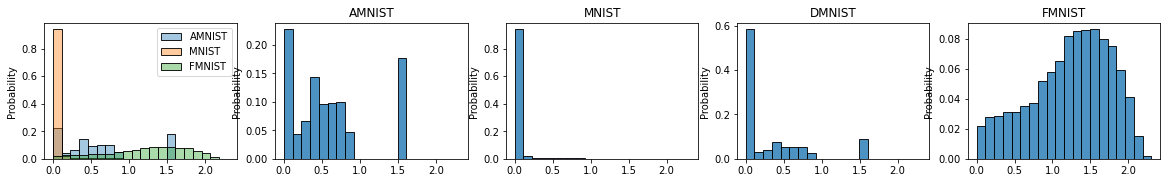

In [50]:
import seaborn as sns


def plot_entropies(p, **kwargs):
    entropies = cat_entropy(p)
    sns.histplot(entropies.cpu().numpy(), stat="probability", binrange=[0, np.log(10)], bins=20, **kwargs)


plt.figure(figsize=(5 * 4, 4 / 1.6))
plt.subplot(1, 5, 1)
plot_entropies(amnist_test_predictions, alpha=0.4, color=sns.color_palette()[0], label="AMNIST")
plot_entropies(mnist_test_predictions, alpha=0.4, color=sns.color_palette()[1], label="MNIST")
plot_entropies(fmnist_test_predictions, alpha=0.4, color=sns.color_palette()[2], label="FMNIST")
plt.legend()

plt.subplot(1, 5, 2)
plot_entropies(amnist_test_predictions, alpha=0.8, color=sns.color_palette()[0], label="AMNIST")
plt.title("AMNIST")
plt.subplot(1, 5, 3)
plot_entropies(mnist_test_predictions, alpha=0.8, color=sns.color_palette()[0], label="MNIST")
plt.title("MNIST")
plt.subplot(1, 5, 4)
plot_entropies(dmnist_test_predictions, alpha=0.8, color=sns.color_palette()[0], label="DMNIST")
plt.title("DMNIST")
plt.subplot(1, 5, 5)
plot_entropies(fmnist_test_predictions, alpha=0.8, color=sns.color_palette()[0], label="FMNIST")
plt.title("FMNIST")

plt.show()